In [527]:
import torch
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import resample
from sklearn.cluster import KMeans
from scipy.linalg import sqrtm
from kneed import KneeLocator

import random
import sys
import warnings
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import Counter
import os
import seaborn as sb

from metrics import *
from Misc import *
from Classifier import NeuralNetwork, LogisticRegression, SVM, RandomForest, DecisionTree
from utils import *
from DatasetExt import *
from influence import *
from Algorithms import *

np.random.seed(42)
torch.manual_seed(1)

## Define Dataset's name

In [528]:
dataset_name='income'

In [529]:
'''state_data_counts = {}
all_states = [state.abbr for state in us.states.STATES]
for state in all_states:
    df= load_acs_data(dataset_name, year='2018', states=[state], horizon='1-Year')
    state_data_counts[state] = df.shape[0]
top_five_states = sorted(state_data_counts, key=state_data_counts.get, reverse=True)[:4]
clustered_data = []
states_name=[]

for state in top_five_states:
    df = load_acs_data(dataset_name, states=[state])
    clustered_data.append((df))'''

In [530]:
'''for state_name, df in zip(top_five_states, clustered_data):
    print(f"Shape of data for {state_name}: {df.shape}")'''

'for state_name, df in zip(top_five_states, clustered_data):\n    print(f"Shape of data for {state_name}: {df.shape}")'

## Load Dataset

In [531]:
datapool, test_orig_df=load_data(dataset_name)
Target_attribute, Sensitive_attribute, protected_group, privileged_group= get_target_sensitive_attribute(dataset_name)
dataset_orig_df = pd.concat([datapool, test_orig_df], ignore_index=True)

## Define Training and Budget Percentages

In [532]:
train_pct=5
train_size=int(dataset_orig_df.shape[0]*(train_pct/100))

In [534]:
train_smart_df= smart_sample(datapool, train_size , 50, 70, dataset_name)  #keep it balance for the sake of accuracy
datapool = datapool.drop(train_smart_df.index)

In [535]:
print("Original dataset: ", dataset_orig_df.shape)
print("Train set: ", train_smart_df.shape)
print("Test set: ", test_orig_df.shape)
print("Size of Data Pool: ", datapool.shape)

Original dataset:  (195665, 11)
Train set:  (9783, 11)
Test set:  (39133, 11)
Size of Data Pool:  (146749, 11)


In [536]:
budget_pct=20
mini_batch_pct=10
data_acq_size=int(datapool.shape[0]*budget_pct//100)
mini_batch_size=int(data_acq_size*(mini_batch_pct/100))
print('mini batch size:', mini_batch_size)
print('Budget Size:', data_acq_size)

mini batch size: 11739
Budget Size: 117399


## Initial Model Training

In [537]:
X_train = train_smart_df.drop(columns=[Target_attribute])
y_train = train_smart_df[Target_attribute]
X_test = test_orig_df.drop(columns=[Target_attribute])
y_test = test_orig_df[Target_attribute]

In [538]:
model_smart=LogisticRegression(input_size=X_train.shape[-1])

In [539]:
X_train, X_test, y_train, y_test, X_train_orig, X_test_orig=prepare_train_data(train_smart_df, test_orig_df, Target_attribute)

In [540]:
num_params = len(convert_grad_to_ndarray(list(model_smart.parameters())))
if isinstance(model_smart, LogisticRegression):
    loss_func = logistic_loss_torch
elif isinstance(model_smart, SVM):
    loss_func = svm_loss_torch
elif isinstance(model_smart, NeuralNetwork):
    loss_func = nn_loss_torch

In [541]:
model_smart.fit(X_train, y_train)
y_pred_test = model_smart.predict_proba(X_test)
y_pred_train = model_smart.predict_proba(X_train)

In [542]:
spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset_name)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset_name)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)


Initial statistical parity:  -0.21509353569193762
Initial TPR parity:  -0.20291867450426027
Initial predictive parity:  -0.08585307896842087
Initial loss:  0.49806339886912543
Initial accuracy:  0.7654664860859122


In [543]:
ini_parity=spd_0
X_train_full, X_test_full, y_train_full, y_test_full, X_train_orig_full, X_test_orig_full=prepare_train_data(dataset_orig_df, test_orig_df, Target_attribute)
model_full=copy.deepcopy(model_smart)
model_full.fit(X_train_full, y_train_full)   
y_pred_test_full=model_full.predict_proba(X_test)
full_parity = computeFairness(y_pred_test_full, X_test_orig, y_test, 0, dataset_name)
ini_acc=computeAccuracy(y_test_full, y_pred_test_full)
print('Initial Parity', ini_parity)
print('Fairness for Entire Data Pool', full_parity)

Initial Parity -0.21509353569193762
Fairness for Entire Data Pool -0.08852007774118792


In [544]:
privileged_positive, privileged_negative, protected_positive, protected_negative, privieleged_data_full, protected_data_full = get_group_count(dataset_orig_df, dataset_name)

## Distribution Check

In [545]:
plt.rcParams['text.usetex'] = False

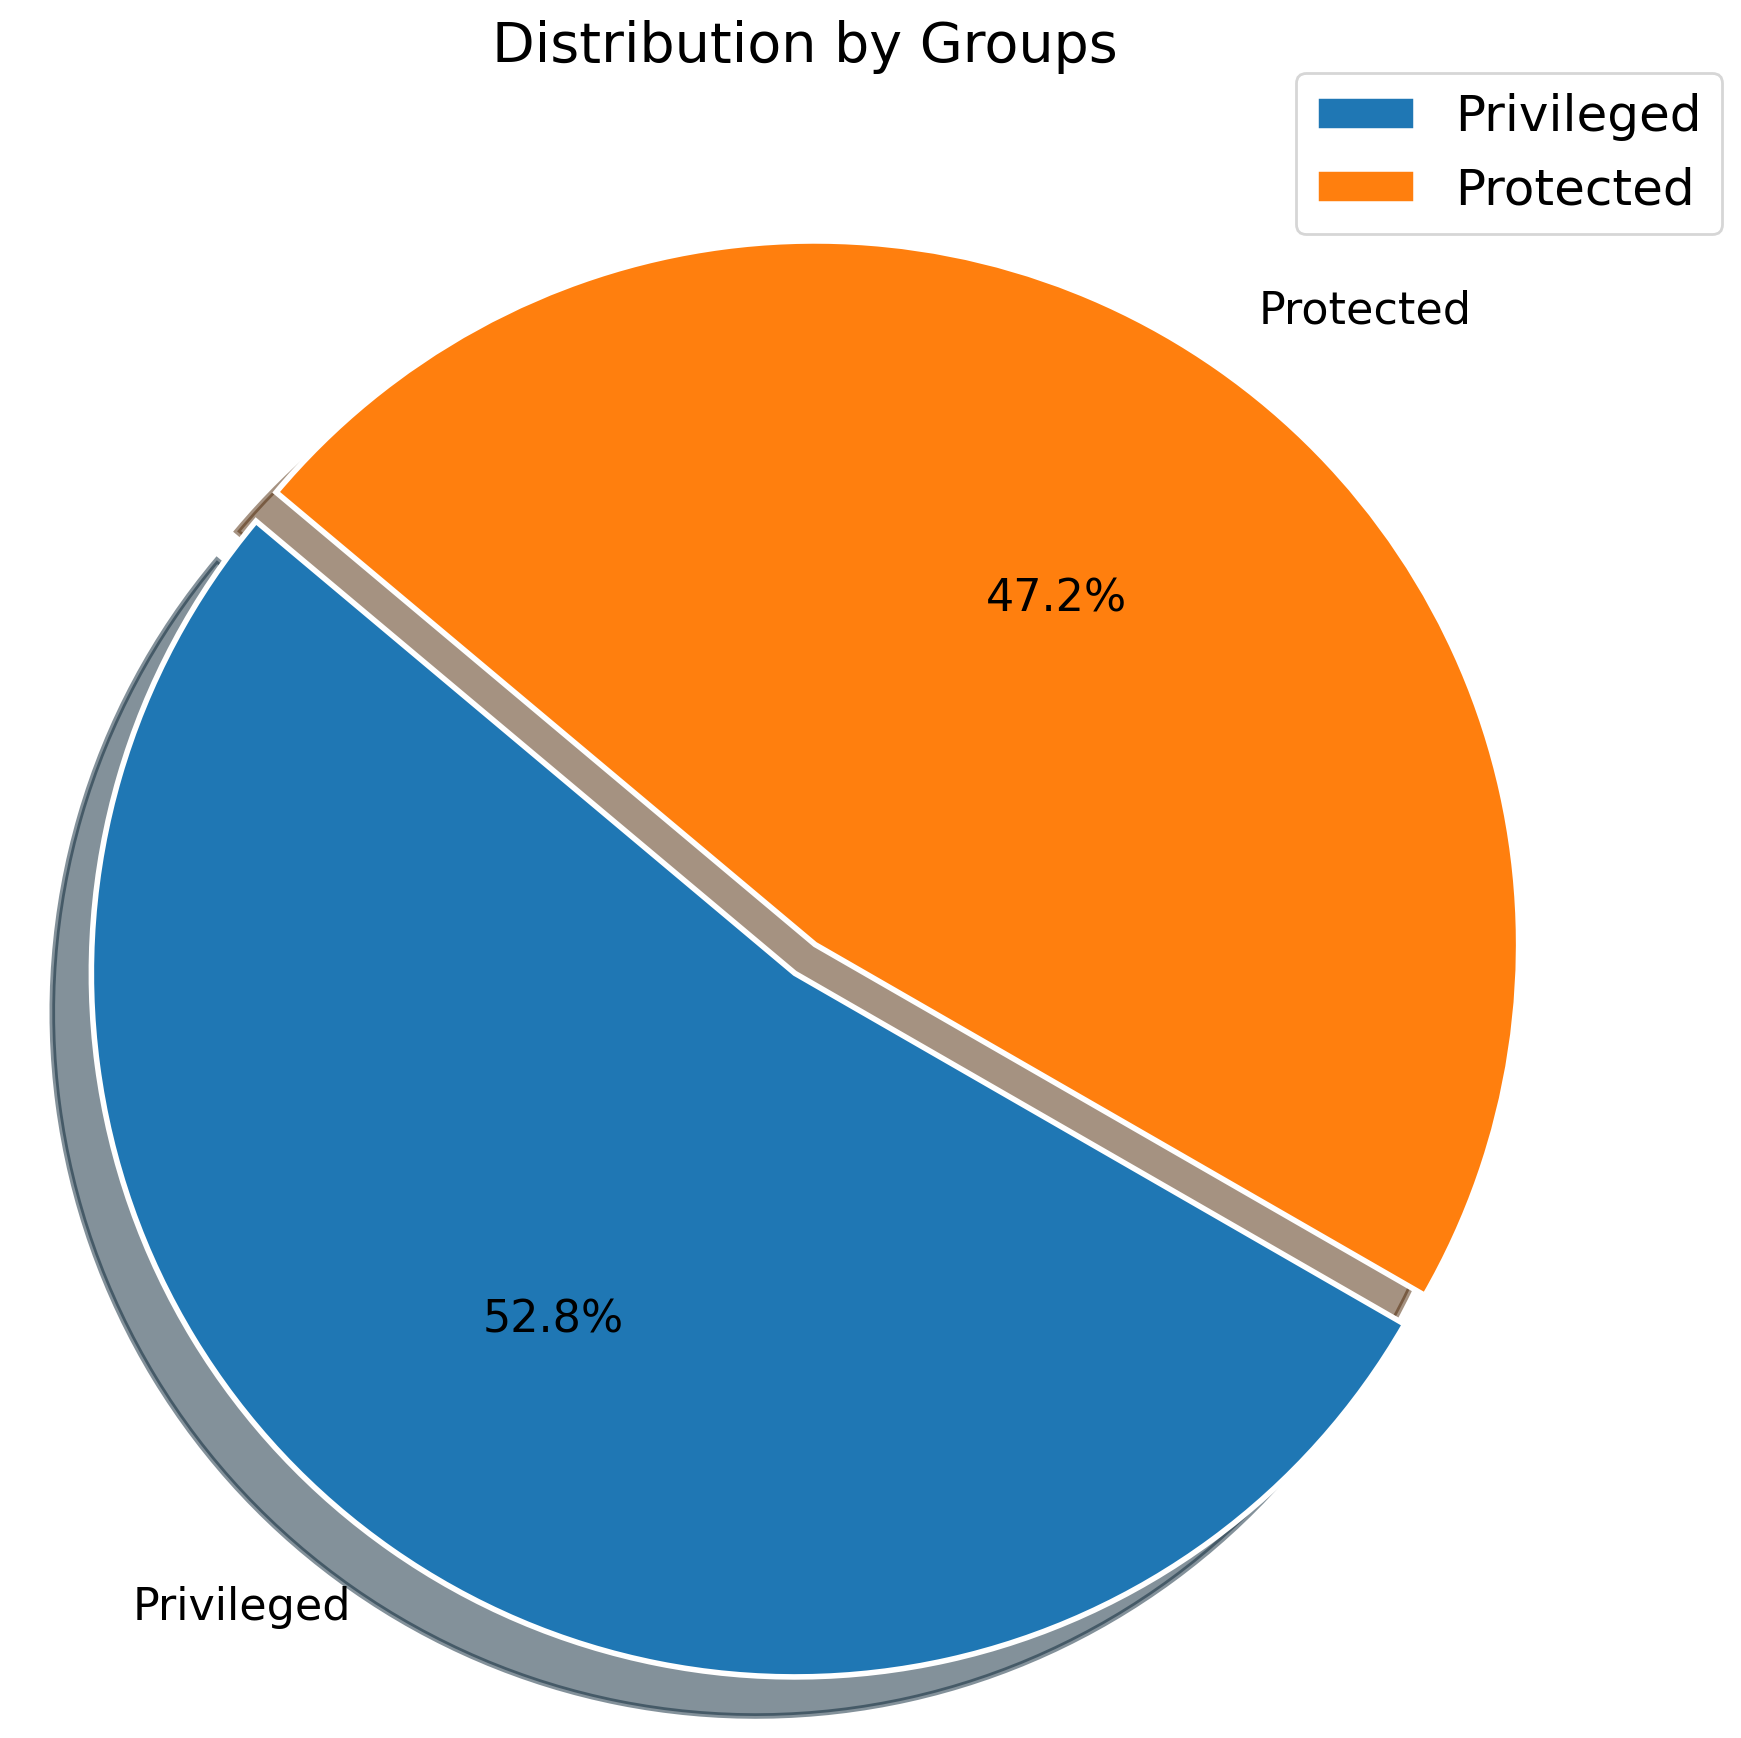

In [546]:

plt.rcParams.update({'font.size': 18, 'font.family': 'DejaVu Sans', 'figure.dpi': 200})

labels = ['Privileged', 'Protected']
values = [privieleged_data_full.shape[0], protected_data_full.shape[0]]

colors = ['#1f77b4', '#ff7f0e']
explode = (0.05, 0)

plt.figure(figsize=(10, 10))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, 
        explode=explode, colors=colors, shadow=True, 
        textprops={'fontsize': 16}, wedgeprops={'linewidth': 2, 'edgecolor': 'white'})

plt.title('Distribution by Groups', fontsize=20, y=1.08)
plt.legend(labels, loc="upper right", bbox_to_anchor=(1.1, 1.1))
plt.axis('equal')
plt.tight_layout(pad=3)
plt.show()

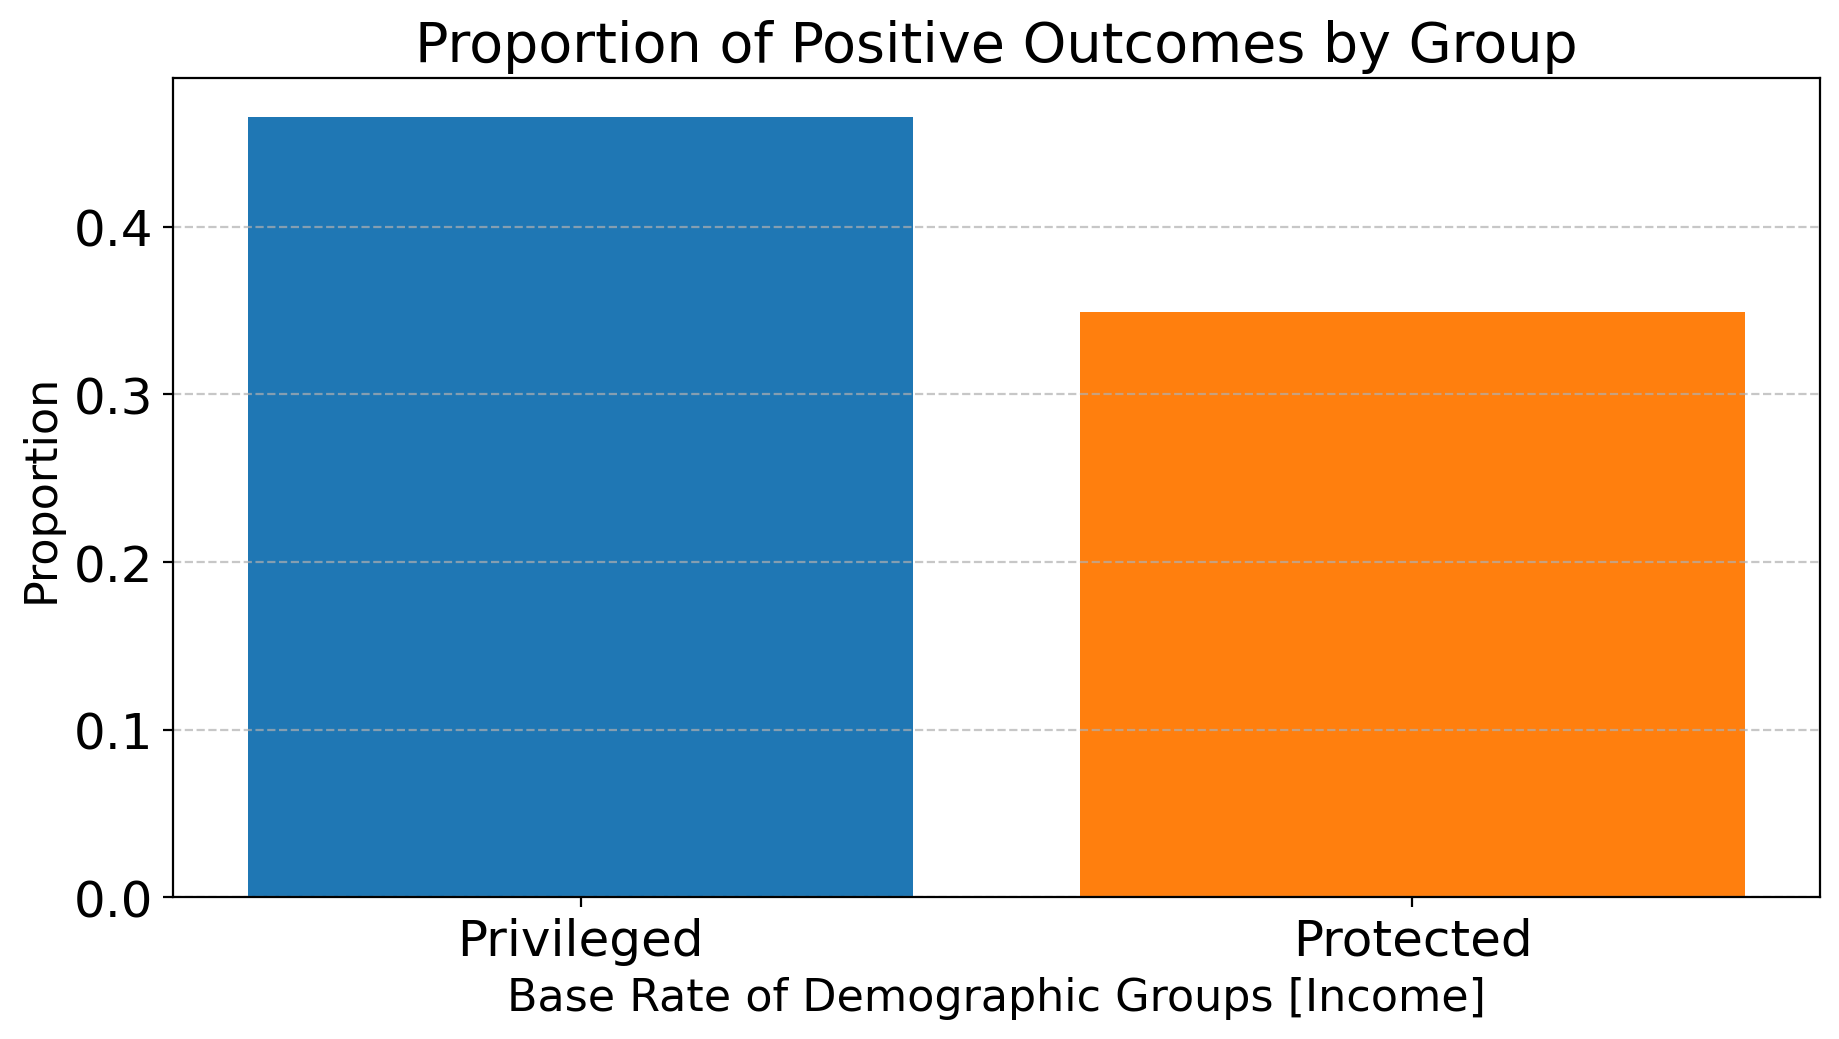

In [547]:
plt.rcParams.update({'font.size': 18, 'font.family': 'DejaVu Sans', 'figure.dpi': 200})

labels = ['Privileged', 'Protected']
values = [privileged_positive.shape[0]/privieleged_data_full.shape[0], 
          protected_positive.shape[0]/protected_data_full.shape[0]]


plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['#1f77b4', '#ff7f0e'])

plt.xlabel('Base Rate of Demographic Groups [Income]', fontsize=16)
plt.ylabel('Proportion', fontsize=16)
plt.title('Proportion of Positive Outcomes by Group', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2)
plt.show()

In [548]:
values

[0.4655554587604418, 0.3490698832752236]

## First Order Influence

In [549]:
metric = 0  # spd -> 0, tpr parity -> 1, predictive parity -> 2
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]

v1 = get_del_F_del_theta(model_smart, X_test_orig, X_test, y_test, dataset_name, metric)
v1=v1.reshape(-1,1)

hessian_all_points = get_hessian_all_points(model_smart, X_train, y_train, loss_func)
del_L_del_theta = get_del_L_del_theta(model_smart, X_train, y_train, loss_func)
hinv_v, hinv = get_hinv_v(hessian_all_points, v1)
Inf_par=(1/X_train.shape[0])*(-del_L_del_theta@hinv)
Influence_loss= -np.dot(hinv, del_L_del_theta.T)
Influence_fair=Inf_par@v1

100%|██████████| 9783/9783 [00:16<00:00, 580.10it/s]


In [550]:
'''X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
difference = []

for index in range(X_train_copy.shape[0]):
    df_dropped_X = np.delete(X_train_copy, index, axis=0)
    df_dropped_y = np.delete(y_train_copy, index, axis=0)
    model = LogisticRegression(input_size=df_dropped_X.shape[-1])
    model.fit(df_dropped_X, df_dropped_y)
    y_pred_test = model.predict_proba(X_test)
    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
    parity_diff = parity - spd_0
    difference.append(parity_diff)'''

'X_train_copy = X_train.copy()\ny_train_copy = y_train.copy()\ndifference = []\n\nfor index in range(X_train_copy.shape[0]):\n    df_dropped_X = np.delete(X_train_copy, index, axis=0)\n    df_dropped_y = np.delete(y_train_copy, index, axis=0)\n    model = LogisticRegression(input_size=df_dropped_X.shape[-1])\n    model.fit(df_dropped_X, df_dropped_y)\n    y_pred_test = model.predict_proba(X_test)\n    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)\n    parity_diff = parity - spd_0\n    difference.append(parity_diff)'

In [551]:
'''plt.figure(figsize=(8, 6))
plt.scatter(difference, Influence_fair, color='b', label='Influence vs Difference', marker='o')
x_values = np.linspace(min(difference), max(difference), 100)
plt.plot(x_values, x_values, color='g', label='y = x', linestyle='-')
plt.xlabel('Difference')
plt.ylabel('Influence Fair')
plt.title('Influence Fair vs Difference')
plt.legend()
plt.grid(True)
plt.show()'''

"plt.figure(figsize=(8, 6))\nplt.scatter(difference, Influence_fair, color='b', label='Influence vs Difference', marker='o')\nx_values = np.linspace(min(difference), max(difference), 100)\nplt.plot(x_values, x_values, color='g', label='y = x', linestyle='-')\nplt.xlabel('Difference')\nplt.ylabel('Influence Fair')\nplt.title('Influence Fair vs Difference')\nplt.legend()\nplt.grid(True)\nplt.show()"

## Second Order Influence

In [552]:
mini_batches = get_minibatches(X_train_orig, mini_batch_size)


In [553]:
'''second_order_influences = []
v1_orig = v1

for batch in mini_batches:
    idx=batch.index
    params_f_2 = second_order_group_influence(idx, del_L_del_theta, hessian_all_points, hinv)
    del_f_2 = np.dot(v1.transpose(), params_f_2)
    second_order_influences.append(del_f_2)'''

'second_order_influences = []\nv1_orig = v1\n\nfor batch in mini_batches:\n    idx=batch.index\n    params_f_2 = second_order_group_influence(idx, del_L_del_theta, hessian_all_points, hinv)\n    del_f_2 = np.dot(v1.transpose(), params_f_2)\n    second_order_influences.append(del_f_2)'

In [554]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

## First Order ground truth check

In [555]:
'''num_batches = (X_train_copy.shape[0] + mini_batch_size - 1) // mini_batch_size
cum_group_inf=[]
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = start_index + mini_batch_size
    group_inf=Influence_fair[start_index:end_index].sum()
    cum_group_inf.append(group_inf)'''

'num_batches = (X_train_copy.shape[0] + mini_batch_size - 1) // mini_batch_size\ncum_group_inf=[]\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = start_index + mini_batch_size\n    group_inf=Influence_fair[start_index:end_index].sum()\n    cum_group_inf.append(group_inf)'

In [556]:
'''difference_group = []
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = min(start_index + mini_batch_size, X_train_copy.shape[0])  
    df_batch_X = X_train_copy[start_index:end_index]
    df_batch_y = y_train_copy[start_index:end_index]
    df_merged_X = np.concatenate((X_train_copy, df_batch_X), axis=0)
    df_merged_y = np.concatenate((y_train_copy, df_batch_y), axis=0)
    model_idx = copy.deepcopy(model_smart)
    model_idx.fit(df_merged_X, df_merged_y)
    y_pred_test = model_idx.predict_proba(X_test)
    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
    parity_diff = parity - spd_0
    difference_group.append(parity_diff)'''


'difference_group = []\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = min(start_index + mini_batch_size, X_train_copy.shape[0])  \n    df_batch_X = X_train_copy[start_index:end_index]\n    df_batch_y = y_train_copy[start_index:end_index]\n    df_merged_X = np.concatenate((X_train_copy, df_batch_X), axis=0)\n    df_merged_y = np.concatenate((y_train_copy, df_batch_y), axis=0)\n    model_idx = copy.deepcopy(model_smart)\n    model_idx.fit(df_merged_X, df_merged_y)\n    y_pred_test = model_idx.predict_proba(X_test)\n    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)\n    parity_diff = parity - spd_0\n    difference_group.append(parity_diff)'

In [557]:
'''plt.figure(figsize=(8, 6))
plt.scatter(difference_group, cum_group_inf, color='b', label='First Order Sum vs Difference_LOO', marker='o')
x_values = np.linspace(min(second_order_influences), max(second_order_influences), 100)
plt.plot(x_values, x_values, color='g', label='y = x', linestyle='-')
plt.xlabel('Difference_LOO')
plt.ylabel('Influence')
plt.title('First Order Sum vs Difference_LOO')
plt.legend()
plt.grid(True)
plt.show()'''

"plt.figure(figsize=(8, 6))\nplt.scatter(difference_group, cum_group_inf, color='b', label='First Order Sum vs Difference_LOO', marker='o')\nx_values = np.linspace(min(second_order_influences), max(second_order_influences), 100)\nplt.plot(x_values, x_values, color='g', label='y = x', linestyle='-')\nplt.xlabel('Difference_LOO')\nplt.ylabel('Influence')\nplt.title('First Order Sum vs Difference_LOO')\nplt.legend()\nplt.grid(True)\nplt.show()"

## Clustering

In [558]:
#optimal_cluster_no=find_optimal_gmm_components(datapool)
#clustered_data=gmm_clustering(datapool,4)

## Influence Estimation for Data Pool

## K-NN

In [559]:
'''sort_by_inf_partition = []
sort_by_inf = []
for data in clustered_data:
    sorted_cluster_data, sorted_influences_fair = sorted_influence_KNN(train_smart_df, data, Influence_fair, k=100)
    sort_by_inf_partition.append(sorted_cluster_data)
    sort_by_inf.append(sorted_influences_fair)'''

'sort_by_inf_partition = []\nsort_by_inf = []\nfor data in clustered_data:\n    sorted_cluster_data, sorted_influences_fair = sorted_influence_KNN(train_smart_df, data, Influence_fair, k=100)\n    sort_by_inf_partition.append(sorted_cluster_data)\n    sort_by_inf.append(sorted_influences_fair)'

## Regression

In [560]:
model_ridge, X_test_poly, y_test_inf= train_reg_model(train_smart_df, Influence_fair, 'Influence')

Ridge R-squared (R²): 0.9935193556203424


## Get Sorted Data Pool

In [561]:
sorted_datapool, datapool_sorted_influences = sorted_influences_reg(datapool, model_ridge)

## Ger Sorted Cluster

In [562]:
sort_by_inf_partition = []
sort_by_inf = []
for data in clustered_data:
    sorted_cluster_data, sorted_influences = sorted_influences_reg(data, model_ridge)
    sort_by_inf_partition.append(sorted_cluster_data)
    sort_by_inf.append(sorted_influences)

## Second order cluster ground truth check

In [563]:
'''cluster_ground_truth = []
num_batches = (sort_by_inf_partition[0].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches
X_train_cl,_, y_train_cl, _, X_train_orig_cl, _= prepare_train_data(sort_by_inf_partition[0], test_orig_df, Target_attribute)
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = min(start_index + mini_batch_size, sort_by_inf_partition[0].shape[0])
    df_dropped_X = np.concatenate((X_train, X_train_cl[start_index: end_index]), axis=0)
    df_dropped_y = np.concatenate((y_train, y_train_cl[start_index: end_index]), axis=0)
    model = LogisticRegression(input_size=df_dropped_X.shape[-1])
    model_idx= copy.deepcopy(model)
    model_idx.fit(df_dropped_X, df_dropped_y)
    y_pred_test = model_idx.predict_proba(X_test)
    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
    parity_diff = parity - spd_0
    cluster_ground_truth.append(parity_diff)'''

'cluster_ground_truth = []\nnum_batches = (sort_by_inf_partition[0].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches\nX_train_cl,_, y_train_cl, _, X_train_orig_cl, _= prepare_train_data(sort_by_inf_partition[0], test_orig_df, Target_attribute)\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = min(start_index + mini_batch_size, sort_by_inf_partition[0].shape[0])\n    df_dropped_X = np.concatenate((X_train, X_train_cl[start_index: end_index]), axis=0)\n    df_dropped_y = np.concatenate((y_train, y_train_cl[start_index: end_index]), axis=0)\n    model = LogisticRegression(input_size=df_dropped_X.shape[-1])\n    model_idx= copy.deepcopy(model)\n    model_idx.fit(df_dropped_X, df_dropped_y)\n    y_pred_test = model_idx.predict_proba(X_test)\n    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)\n    parity_diff = parity - spd_0\n    cluster_ground_truth.append(parity_diff)'

In [564]:
'''num_batches = (sort_by_inf[0].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches
print(num_batches)
cum_group_inf=[]
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = start_index + mini_batch_size
    group_inf=sort_by_inf[1][start_index:end_index].sum()
    cum_group_inf.append(group_inf)'''

'num_batches = (sort_by_inf[0].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches\nprint(num_batches)\ncum_group_inf=[]\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = start_index + mini_batch_size\n    group_inf=sort_by_inf[1][start_index:end_index].sum()\n    cum_group_inf.append(group_inf)'

In [565]:
'''plt.figure(figsize=(8, 6))
plt.plot(range(1,num_batches+1), cum_group_inf, color='r', linestyle='-', label='Estimation for each mini-batch from Cluster')
plt.plot(range(1,num_batches+1), cluster_ground_truth, color='g', linestyle='-', label='Ground Truth')
plt.xlabel('Batches')
plt.ylabel('Estimated Influence for cluster')
plt.title('Ground Truth Vs Estimation')
plt.legend()
plt.grid(True)
plt.show()'''

"plt.figure(figsize=(8, 6))\nplt.plot(range(1,num_batches+1), cum_group_inf, color='r', linestyle='-', label='Estimation for each mini-batch from Cluster')\nplt.plot(range(1,num_batches+1), cluster_ground_truth, color='g', linestyle='-', label='Ground Truth')\nplt.xlabel('Batches')\nplt.ylabel('Estimated Influence for cluster')\nplt.title('Ground Truth Vs Estimation')\nplt.legend()\nplt.grid(True)\nplt.show()"

## Equal Representation

In [566]:
'''protected_full_sample = protected_data_full.sample(n=int(data_acq_size/2), random_state=42)
privileged_full_sample = privieleged_data_full.sample(n=int(data_acq_size/2), random_state=42)
print(protected_full_sample.shape)'''

'protected_full_sample = protected_data_full.sample(n=int(data_acq_size/2), random_state=42)\nprivileged_full_sample = privieleged_data_full.sample(n=int(data_acq_size/2), random_state=42)\nprint(protected_full_sample.shape)'

In [567]:
'''from copy import deepcopy

parity_differences = [ini_parity]
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
for pct in percentages:
    protected_sample = protected_full_sample.sample(frac=pct, random_state=42)
    privileged_sample = privileged_full_sample.sample(n=protected_sample.shape[0], random_state=42)

    full_sample = pd.concat([protected_sample, privileged_sample])
    combined_sample_pct=pd.concat([train_smart_df, full_sample])
    
    X_train_pct, X_test_pct, y_train_pct, y_test_pct, X_train_orig_pct, X_test_orig_pct=prepare_train_data(combined_sample_pct, test_orig_df, Target_attribute)
    model_pct=LogisticRegression(input_size=X_train_pct.shape[-1])
    model_pct.fit(X_train_pct, y_train_pct)
   
    y_pred_test_pct=model_pct.predict_proba(X_test)
    parity = computeFairness(y_pred_test_pct, X_test_orig_pct, y_test_pct, 0, dataset_name)
    parity_differences.append(parity)
percentages.insert(0,0)'''

'from copy import deepcopy\n\nparity_differences = [ini_parity]\npercentages = [0.2, 0.4, 0.6, 0.8, 1.0]\nfor pct in percentages:\n    protected_sample = protected_full_sample.sample(frac=pct, random_state=42)\n    privileged_sample = privileged_full_sample.sample(n=protected_sample.shape[0], random_state=42)\n\n    full_sample = pd.concat([protected_sample, privileged_sample])\n    combined_sample_pct=pd.concat([train_smart_df, full_sample])\n    \n    X_train_pct, X_test_pct, y_train_pct, y_test_pct, X_train_orig_pct, X_test_orig_pct=prepare_train_data(combined_sample_pct, test_orig_df, Target_attribute)\n    model_pct=LogisticRegression(input_size=X_train_pct.shape[-1])\n    model_pct.fit(X_train_pct, y_train_pct)\n   \n    y_pred_test_pct=model_pct.predict_proba(X_test)\n    parity = computeFairness(y_pred_test_pct, X_test_orig_pct, y_test_pct, 0, dataset_name)\n    parity_differences.append(parity)\npercentages.insert(0,0)'

In [568]:
'''folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/MAB Data Acqusiition/Plots/Equal_Representation'
file_name = 'equal_representation_uneq.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(8, 6))
#plt.plot(percentages, parity_differences_eq, marker='s', color='b', label='Balance Training Data')
plt.plot(percentages, parity_differences, marker='s', color='r', label='Imbalance Training Data')

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
plt.xlabel('Acquired Data Percentages of Budget (Equal Representation)')
plt.ylabel('Fairness Metric')
plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.05))'''

#plt.savefig(file_path, format='pdf', dpi=600)

"folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/MAB Data Acqusiition/Plots/Equal_Representation'\nfile_name = 'equal_representation_uneq.pdf'\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\n\nplt.figure(figsize=(8, 6))\n#plt.plot(percentages, parity_differences_eq, marker='s', color='b', label='Balance Training Data')\nplt.plot(percentages, parity_differences, marker='s', color='r', label='Imbalance Training Data')\n\nplt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))\nplt.xlabel('Acquired Data Percentages of Budget (Equal Representation)')\nplt.ylabel('Fairness Metric')\nplt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.05))"

In [569]:
'''table_eq = {
    'Acquired Data Percentages of Budget (%)': [int(pct * 100) for pct in percentages],
    'Fairness Metric': parity_differences
}

table = pd.DataFrame(table_eq)
table['Acquired Data Percentages of Budget (%)'] = table['Acquired Data Percentages of Budget (%)'].apply(lambda x: f'{x}%')
table.iloc[0, 0] = 'Initial'
table['Fairness Metric'] = table['Fairness Metric'].round(2)
file_path = os.path.join(folder_path, "fairness_metric_table_uneq_train.jpg")

plt.figure(figsize=(8, 1.8))
plt.table(cellText=table.values, colLabels=table.columns, cellLoc='center', loc='center', colColours=["lightblue"]*2)
plt.axis('off')
plt.title('Training Data has Imbalance Representation(Equal Representation)')

#plt.savefig(file_path, format='jpg', bbox_inches='tight', dpi=600)

plt.show()'''

'table_eq = {\n    \'Acquired Data Percentages of Budget (%)\': [int(pct * 100) for pct in percentages],\n    \'Fairness Metric\': parity_differences\n}\n\ntable = pd.DataFrame(table_eq)\ntable[\'Acquired Data Percentages of Budget (%)\'] = table[\'Acquired Data Percentages of Budget (%)\'].apply(lambda x: f\'{x}%\')\ntable.iloc[0, 0] = \'Initial\'\ntable[\'Fairness Metric\'] = table[\'Fairness Metric\'].round(2)\nfile_path = os.path.join(folder_path, "fairness_metric_table_uneq_train.jpg")\n\nplt.figure(figsize=(8, 1.8))\nplt.table(cellText=table.values, colLabels=table.columns, cellLoc=\'center\', loc=\'center\', colColours=["lightblue"]*2)\nplt.axis(\'off\')\nplt.title(\'Training Data has Imbalance Representation(Equal Representation)\')\n\n#plt.savefig(file_path, format=\'jpg\', bbox_inches=\'tight\', dpi=600)\n\nplt.show()'

## Algorithms

## MAB Acquisition

In [570]:
tau=0.01

In [571]:
Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=20, tau=tau, budget=data_acq_size, alpha=0.1)

## MAB_INF Acquisition

In [572]:
MAB_inf_update_data, MAB_inf_iteration_count, MAB_inf_iteration_count_ex, MAB_inf_parity_ex, stat_MAB_inf, MAB_inf_accuracy_ex, MAB_inf_time_per_iteration, MAB_inf_cluster_count, iteration_time_MAB_inf = mab_inf_algorithm(sort_by_inf_partition, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=20, tau=tau, budget=data_acq_size, alpha=0.1)

## MAB_dist

In [573]:
normalized_distance=compute_normalized_distances(clustered_data)

In [574]:
Stat_update_data_dist, i_values_stat_dist, i_values_ex_stat_dist, stat_ex_dist, stat_dist, acc_stat_dist, time_per_iteration_stat_dist, cluster_count_dist, iteration_time1_dist = mab_algorithm_dist(clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=20, tau=tau, budget=data_acq_size, Euclid_normalized_d=normalized_distance, alpha=0.1)

## Random Acquisition

In [575]:
data_random, i_values_ex_ran, i_values_ran, stat_ran, stat_ex_ran, acc_ran, time_per_iteration_ran =random_algorithm(datapool, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, tau=tau, budget=data_acq_size)

## Entropy

In [576]:
data_entropy, i_values_ex_ent, i_values_ent, stat_ent, stat_ex_ent, acc_ent, time_per_iteration_ent =random_algorithm(datapool, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, tau=tau, budget=data_acq_size)

## Only Influence

In [577]:
data_inf, i_values_ex_inf, i_values_inf, stat_inf, stat_ex_inf, acc_inf, time_per_iteration_inf =inf_algorithm(sorted_datapool, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, tau=tau, budget=data_acq_size)

In [578]:
'''import matplotlib.ticker as mticker
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/MAB Data Acqusiition/Plots/Equal_Representation'
file_name = 'Eq_Random_Acq.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(8, 6))
#plt.plot(percentages, stat_ran, marker='s', color='b', label='ImBalance Training Data')
#plt.plot(percentages, stat_ran_eq, marker='s', color='b', label='Balanced TD: Random Acquisition')
plt.plot(percentages, stat_ran, marker='s', color='r', label='Imbalanced TD: Random Acquisition')
#plt.plot(percentages, parity_differences_eq, marker='s', color='lightblue', label='Balanced TD: Equal Representation')
plt.plot(percentages, parity_differences, marker='s', color='orange', label='Imbalanced TD: Equal Representation')

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
plt.xlabel('Acquired Data Percentages of Budget')
plt.ylabel('Fairness Metric')
plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.05))

plt.savefig(file_path, format='pdf', dpi=600)'''

"import matplotlib.ticker as mticker\nfolder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/MAB Data Acqusiition/Plots/Equal_Representation'\nfile_name = 'Eq_Random_Acq.pdf'\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\n\nplt.figure(figsize=(8, 6))\n#plt.plot(percentages, stat_ran, marker='s', color='b', label='ImBalance Training Data')\n#plt.plot(percentages, stat_ran_eq, marker='s', color='b', label='Balanced TD: Random Acquisition')\nplt.plot(percentages, stat_ran, marker='s', color='r', label='Imbalanced TD: Random Acquisition')\n#plt.plot(percentages, parity_differences_eq, marker='s', color='lightblue', label='Balanced TD: Equal Representation')\nplt.plot(percentages, parity_differences, marker='s', color='orange', label='Imbalanced TD: Equal Representation')\n\nplt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))\nplt.xlabel('Acquired Data Percentag

In [579]:
'''table_eq = {
    'Acquired Data Percentages of Budget (%)': [int(pct * 100) for pct in percentages],
    'Fairness Metric': stat_ran
}

table = pd.DataFrame(table_eq)
table['Acquired Data Percentages of Budget (%)'] = table['Acquired Data Percentages of Budget (%)'].apply(lambda x: f'{x}%')
table.iloc[0, 0] = 'Initial'
table['Fairness Metric'] = table['Fairness Metric'].round(2)
file_path = os.path.join(folder_path, "fairness_metric_table_ran_uneq_train.jpg")

plt.figure(figsize=(8, 1.8))
plt.table(cellText=table.values, colLabels=table.columns, cellLoc='center', loc='center', colColours=["lightblue"]*2)
plt.axis('off')
plt.title('Training Data has Imbalance Representation(Random)')

plt.savefig(file_path, format='jpg', bbox_inches='tight', dpi=600)

plt.show()'''

'table_eq = {\n    \'Acquired Data Percentages of Budget (%)\': [int(pct * 100) for pct in percentages],\n    \'Fairness Metric\': stat_ran\n}\n\ntable = pd.DataFrame(table_eq)\ntable[\'Acquired Data Percentages of Budget (%)\'] = table[\'Acquired Data Percentages of Budget (%)\'].apply(lambda x: f\'{x}%\')\ntable.iloc[0, 0] = \'Initial\'\ntable[\'Fairness Metric\'] = table[\'Fairness Metric\'].round(2)\nfile_path = os.path.join(folder_path, "fairness_metric_table_ran_uneq_train.jpg")\n\nplt.figure(figsize=(8, 1.8))\nplt.table(cellText=table.values, colLabels=table.columns, cellLoc=\'center\', loc=\'center\', colColours=["lightblue"]*2)\nplt.axis(\'off\')\nplt.title(\'Training Data has Imbalance Representation(Random)\')\n\nplt.savefig(file_path, format=\'jpg\', bbox_inches=\'tight\', dpi=600)\n\nplt.show()'

## Multi-Armed Bandit Vs Others

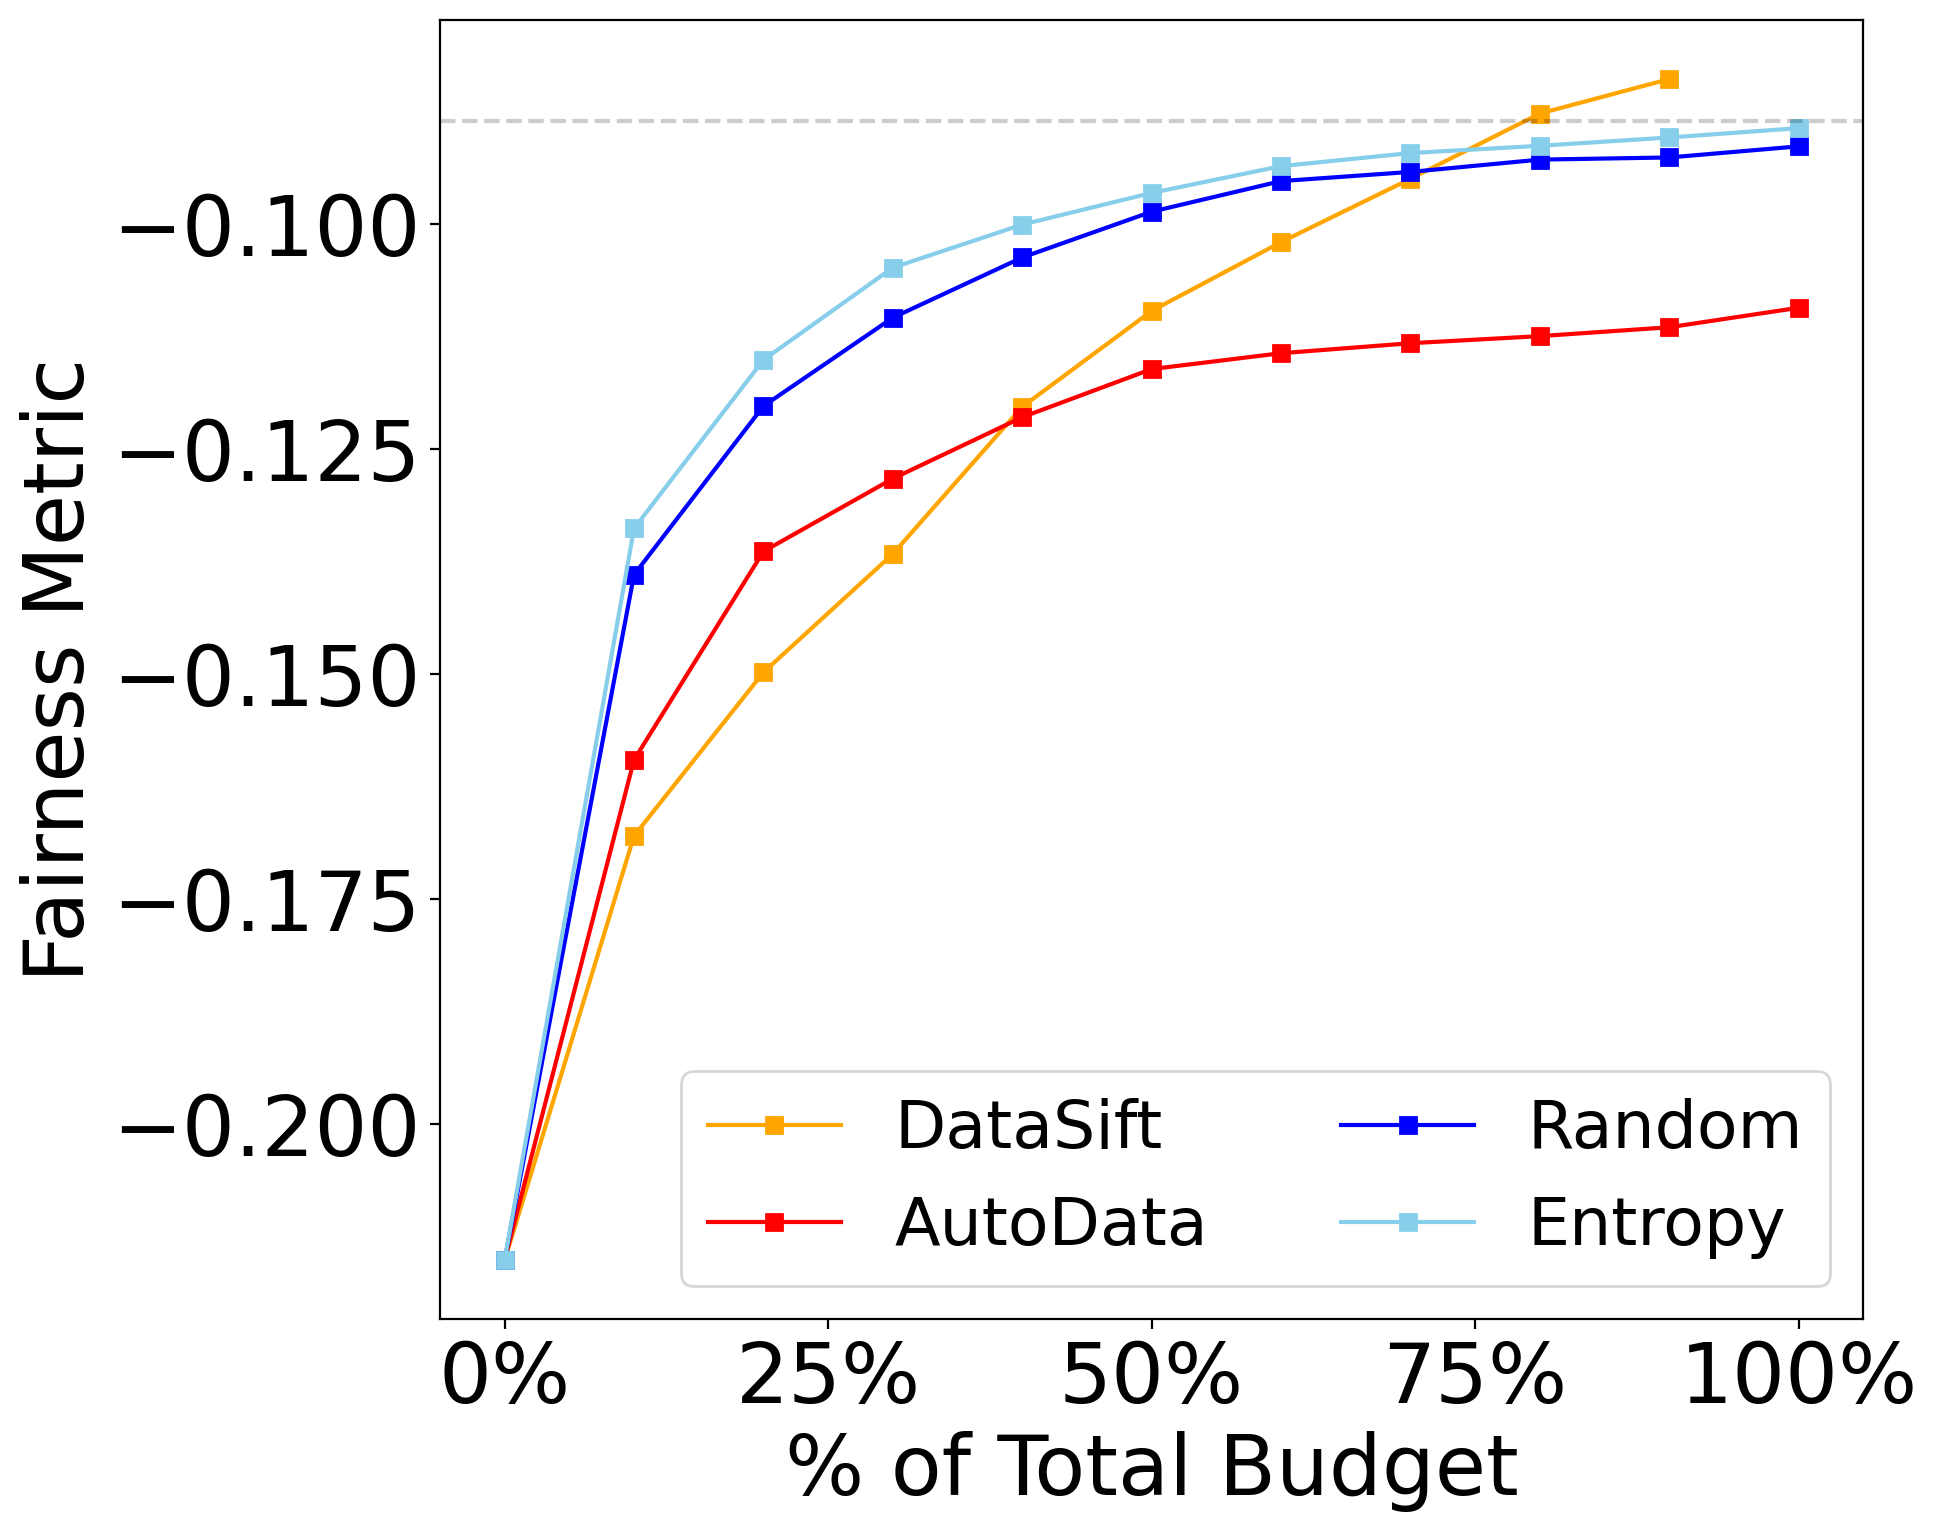

In [580]:
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/DataSift Final'
file_name = 'adult.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(10,8))

plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='orange', marker='s', linestyle='-', label='DataSift',
)
plt.plot(
    [i for i in i_values_ex_stat_dist if i % 1 == 0], 
    [stat_ex_dist[i_values_ex_stat_dist.index(i)] for i in i_values_ex_stat_dist if i % 1 == 0], 
    color='r', marker='s', linestyle='-', label='AutoData'
)
plt.plot(
    [i for i in i_values_ex_ran if i % 1 == 0], 
    [stat_ex_ran[i_values_ex_ran.index(i)] for i in i_values_ex_ran if i % 1 == 0], 
    color='b', marker='s', linestyle='-', label='Random'
)

plt.plot(
    [i for i in i_values_ex_ent if i % 1 == 0], 
    [stat_ex_ent[i_values_ex_ent.index(i)] for i in i_values_ex_ent if i % 1 == 0], 
    color='skyblue', marker='s', linestyle='-', label='Entropy'
)

plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=24, ncol=2)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()


#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()


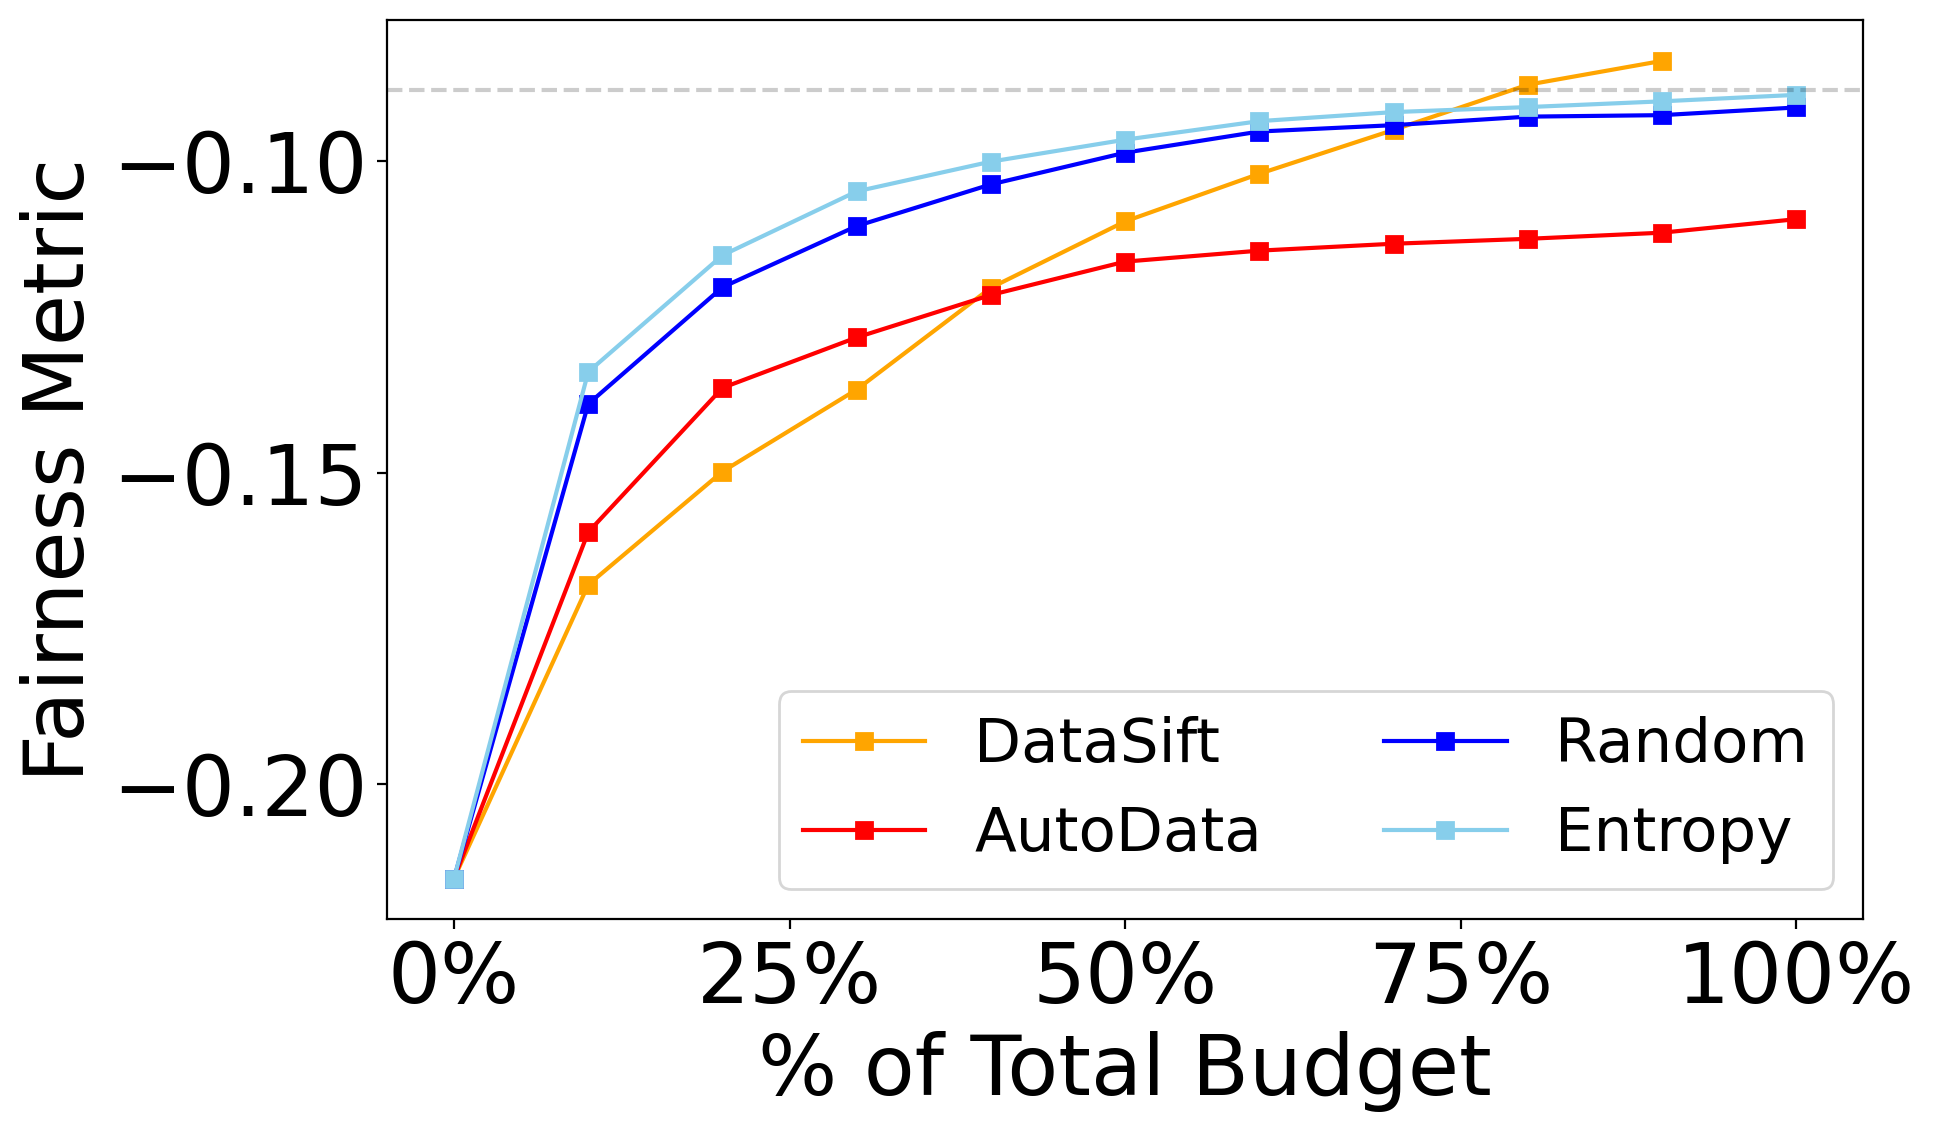

In [581]:
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/DataSift Final'
file_name = 'income_rec_LR.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(10,6))

plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='orange', marker='s', linestyle='-', label='DataSift',
)
plt.plot(
    [i for i in i_values_ex_stat_dist if i % 1 == 0], 
    [stat_ex_dist[i_values_ex_stat_dist.index(i)] for i in i_values_ex_stat_dist if i % 1 == 0], 
    color='r', marker='s', linestyle='-', label='AutoData'
)
plt.plot(
    [i for i in i_values_ex_ran if i % 1 == 0], 
    [stat_ex_ran[i_values_ex_ran.index(i)] for i in i_values_ex_ran if i % 1 == 0], 
    color='b', marker='s', linestyle='-', label='Random'
)

plt.plot(
    [i for i in i_values_ex_ent if i % 1 == 0], 
    [stat_ex_ent[i_values_ex_ent.index(i)] for i in i_values_ex_ent if i % 1 == 0], 
    color='skyblue', marker='s', linestyle='-', label='Entropy'
)


plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=22, ncol=2)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()


#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()

## Data Valuation

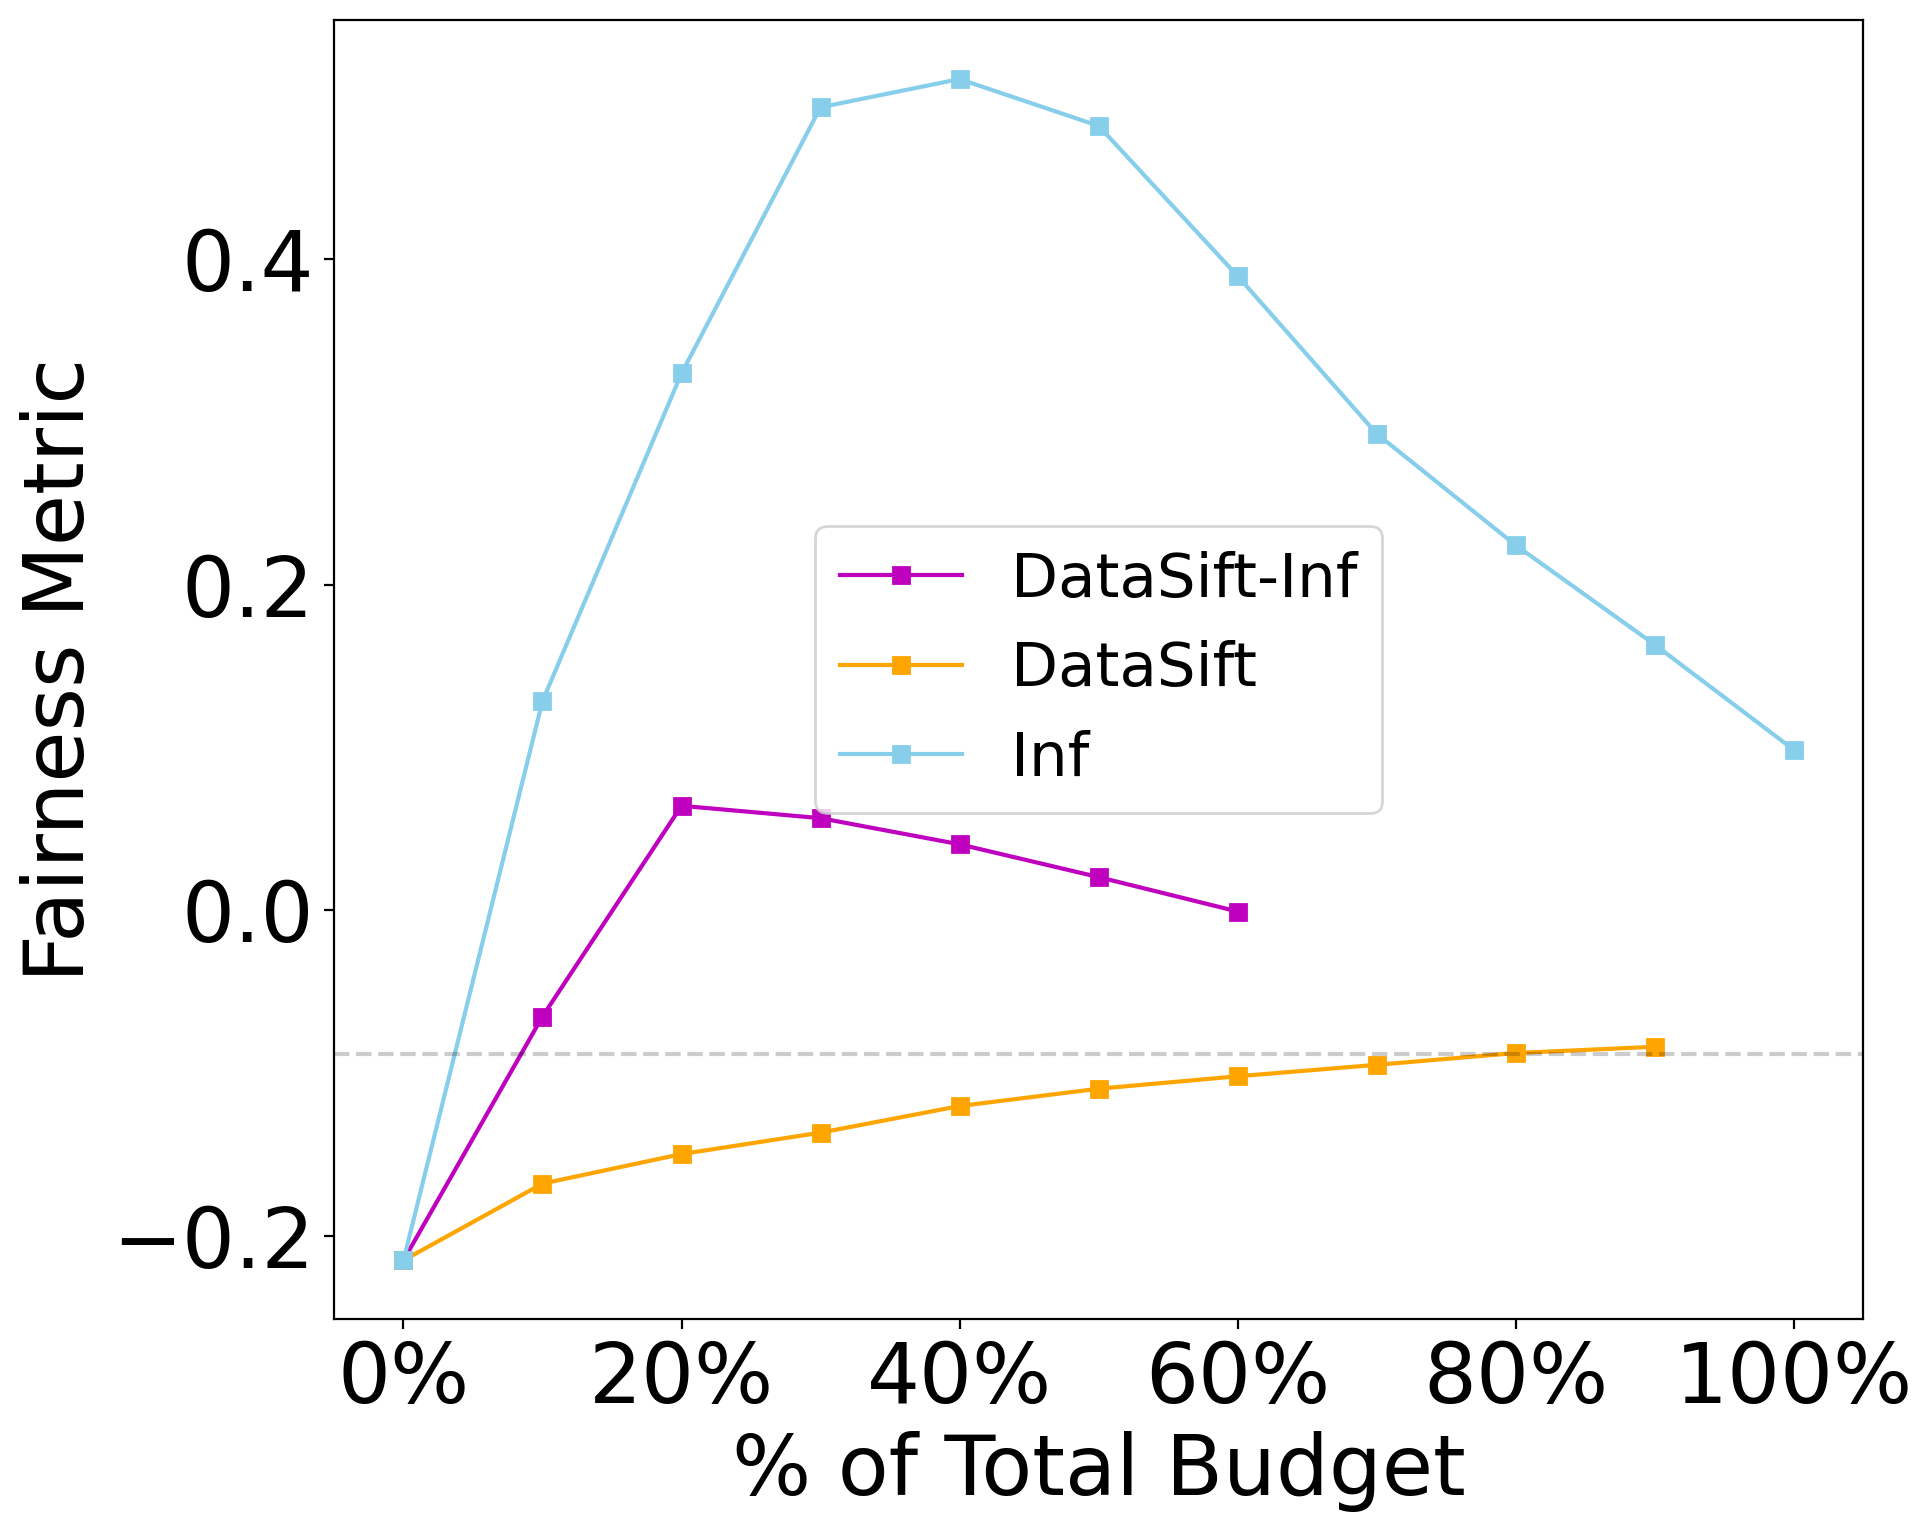

In [582]:
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/DataSift Inf Final'
file_name = 'Credit_sq.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(10, 8))
plt.plot(
    [i for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    [MAB_inf_parity_ex[MAB_inf_iteration_count_ex.index(i)] for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    color='m', marker='s', linestyle='-', label='DataSift-Inf'
)
plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='orange', marker='s', linestyle='-', label='DataSift'
)
plt.plot(
    [i for i in i_values_ex_inf if i % 1 == 0], 
    [stat_ex_inf[i_values_ex_inf.index(i)] for i in i_values_ex_inf if i % 1 == 0], 
    color='skyblue', marker='s', linestyle='-', label='Inf'
)


plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=22, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()


#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()


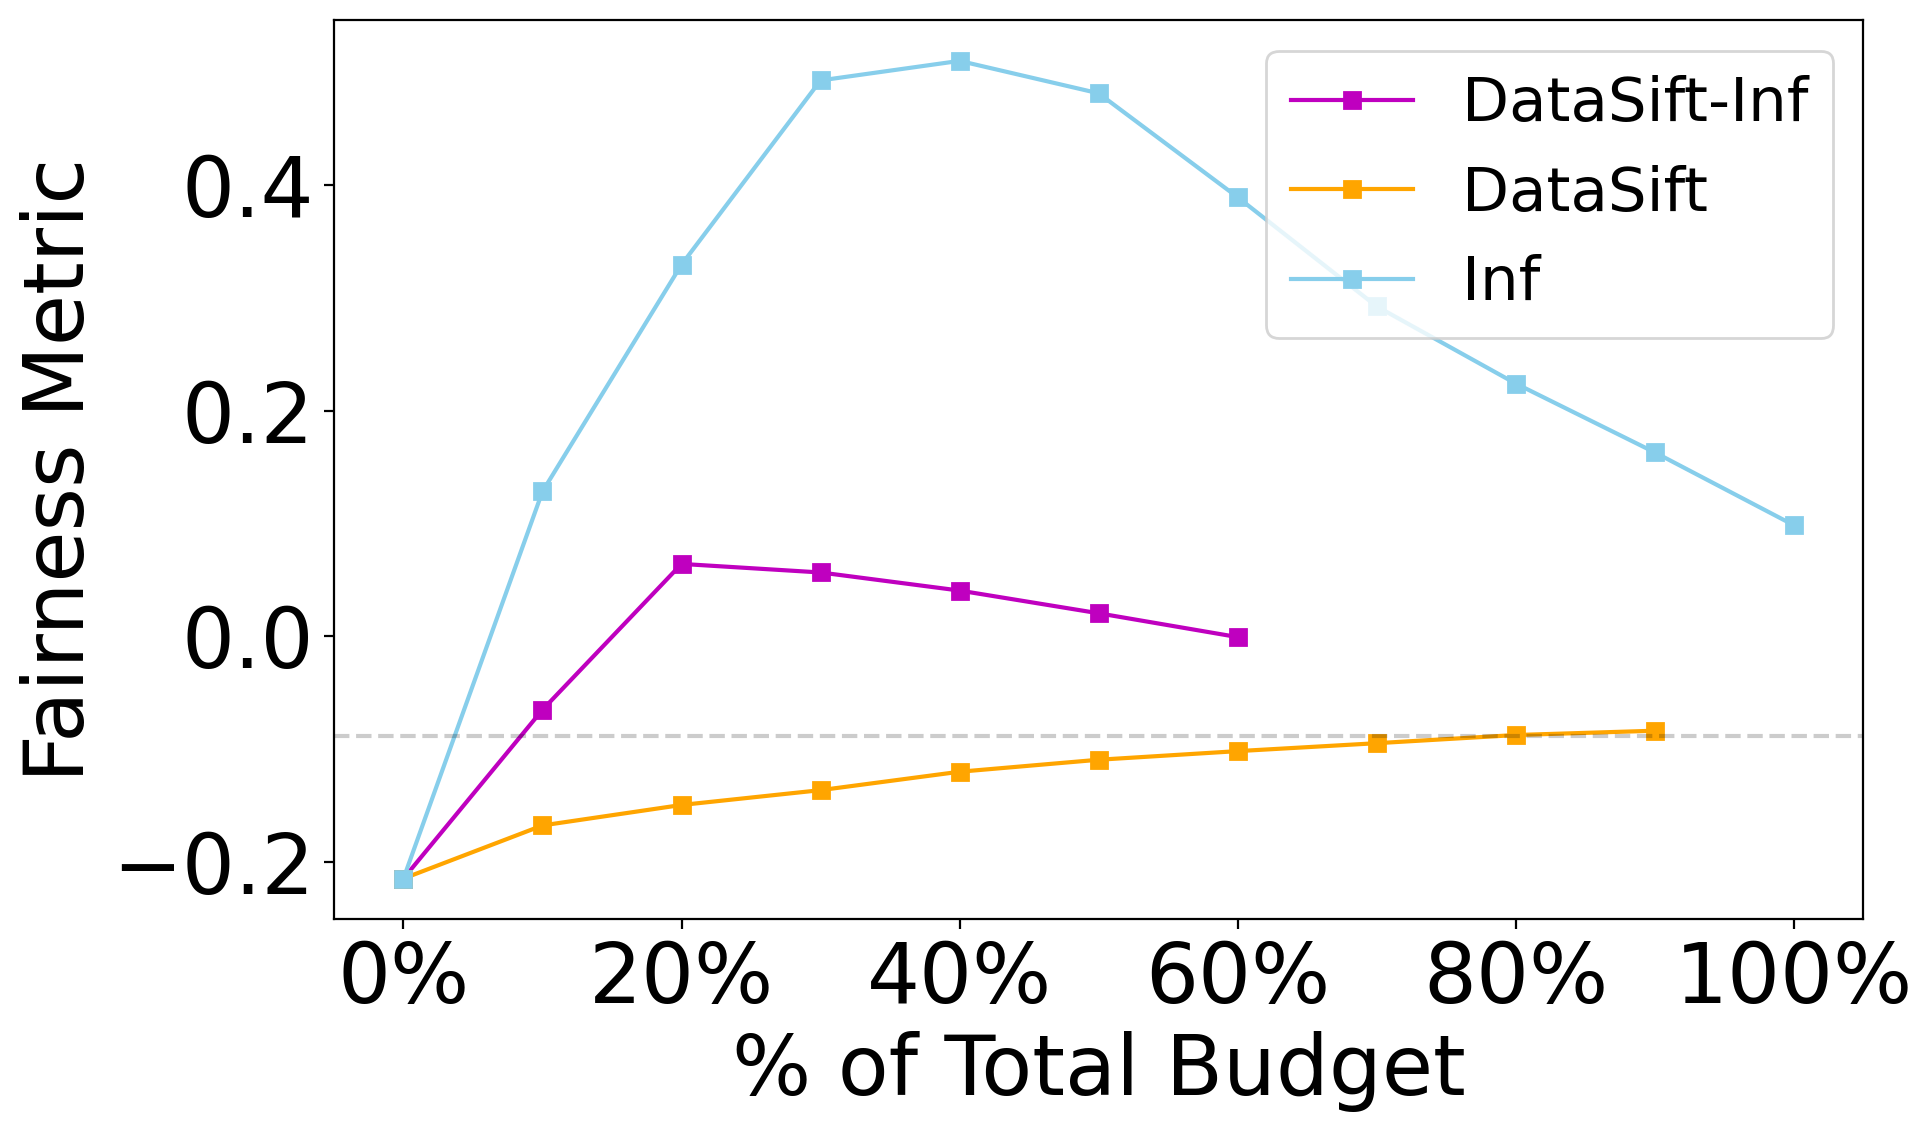

In [583]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/DataSift Inf Final'
file_name = 'Credit_rec.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(10, 6))
plt.plot(
    [i for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    [MAB_inf_parity_ex[MAB_inf_iteration_count_ex.index(i)] for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    color='m', marker='s', linestyle='-', label='DataSift-Inf'
)
plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='orange', marker='s', linestyle='-', label='DataSift'
)
plt.plot(
    [i for i in i_values_ex_inf if i % 1 == 0], 
    [stat_ex_inf[i_values_ex_inf.index(i)] for i in i_values_ex_inf if i % 1 == 0], 
    color='skyblue', marker='s', linestyle='-', label='Inf'
)


plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=22, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()


#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()

## Data Valuation In each Iteration

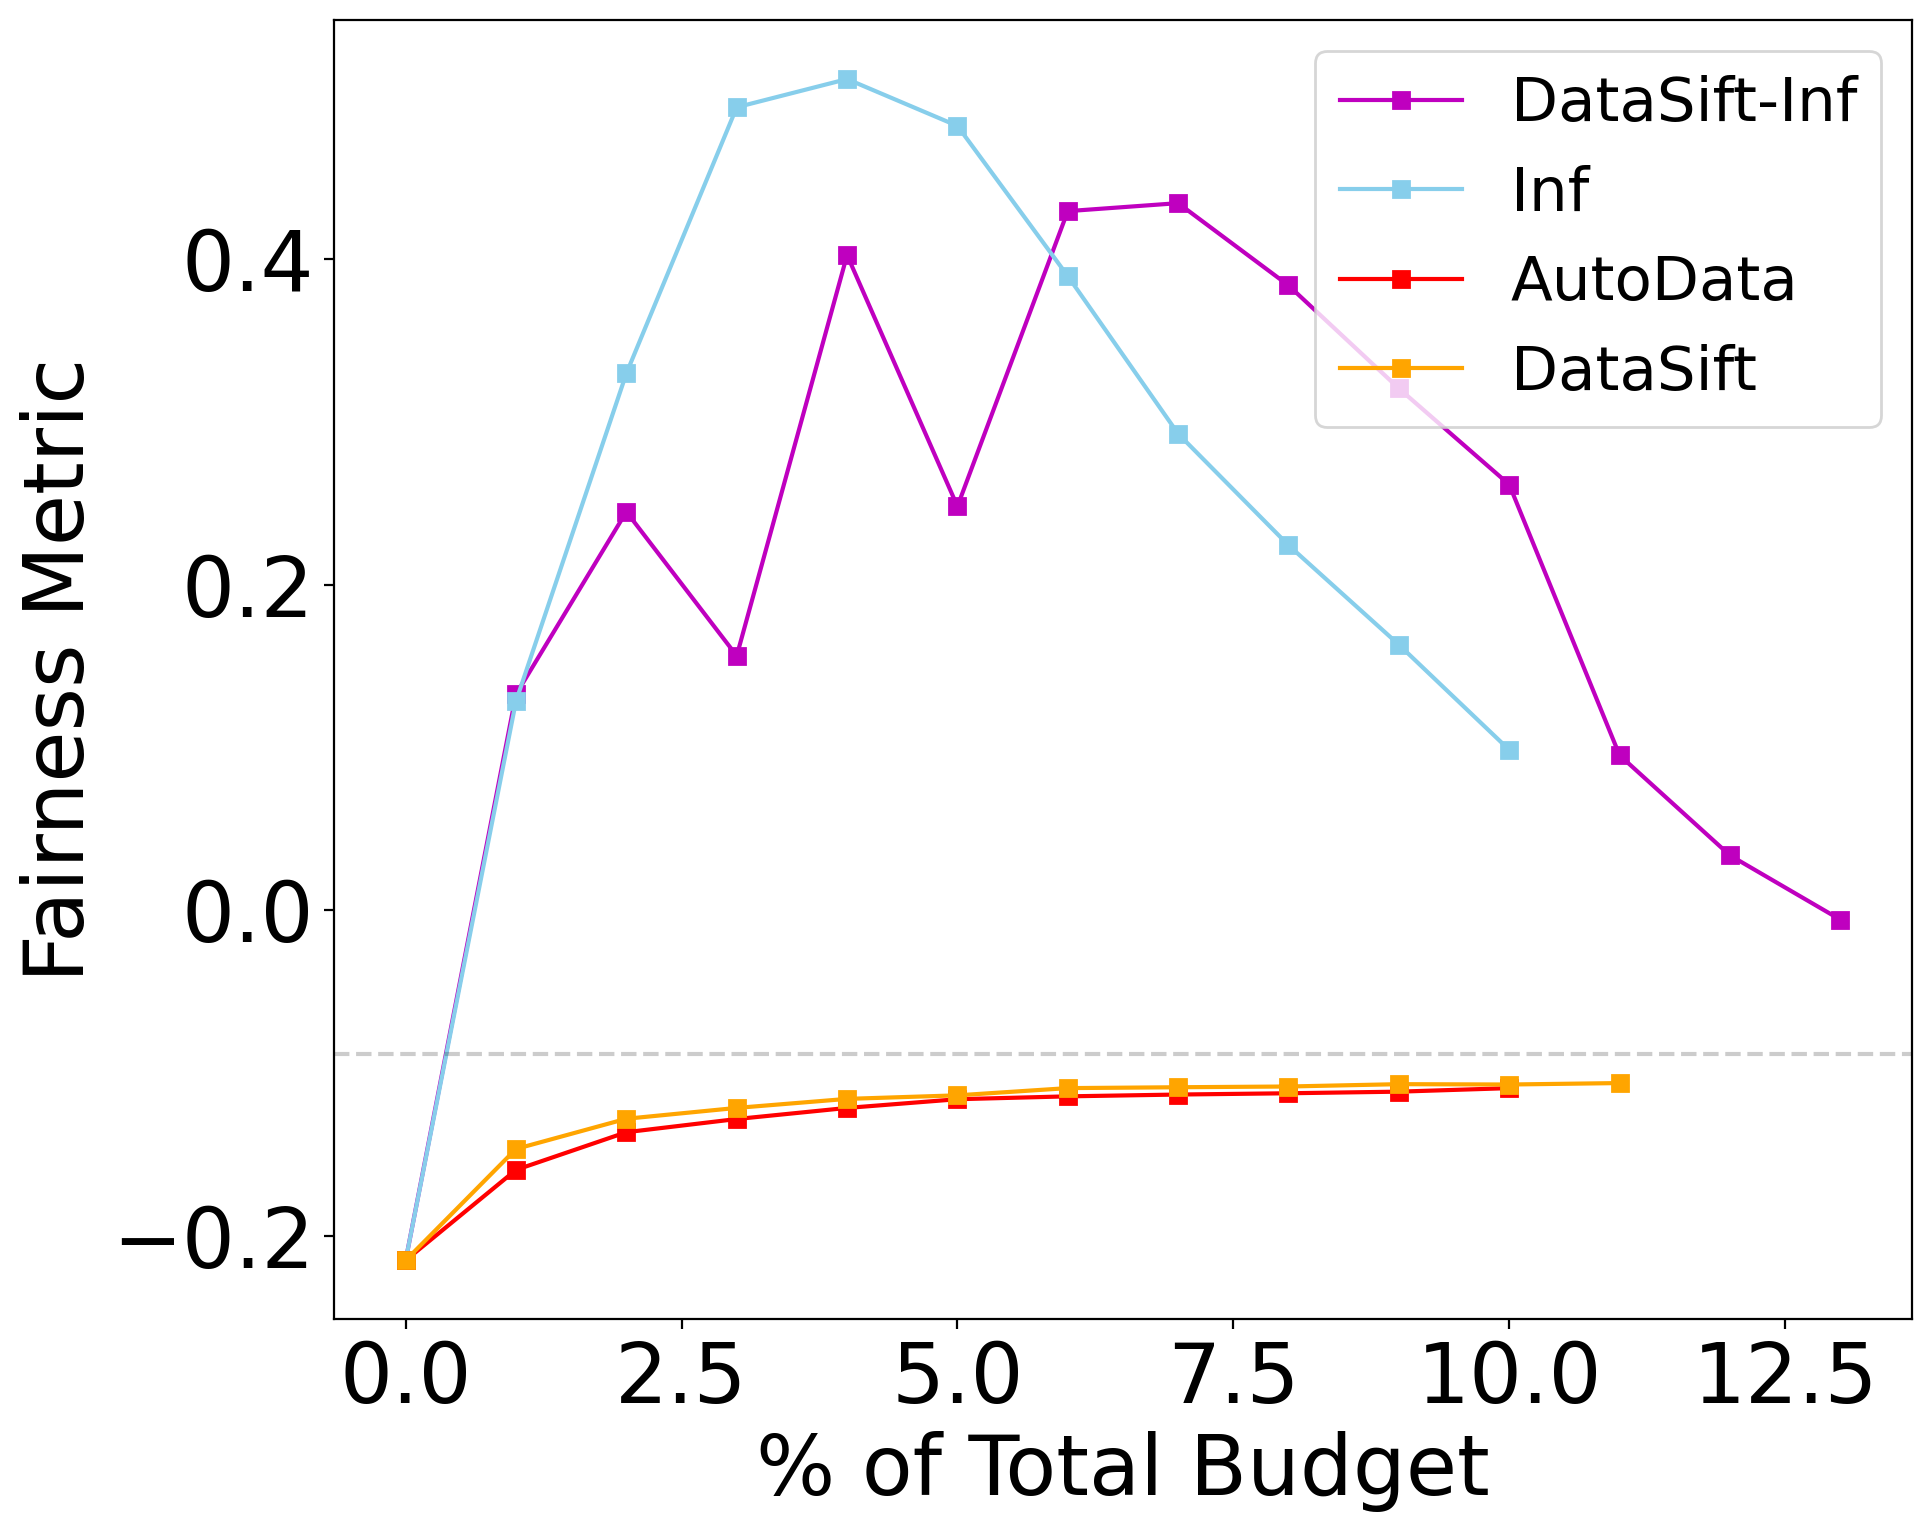

In [584]:
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/DataSift Final'
file_name = 'Public_all_iteration.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(10,8))


plt.plot(
    [i for i in MAB_inf_iteration_count if i % 1 == 0], 
    [stat_MAB_inf[MAB_inf_iteration_count.index(i)] for i in MAB_inf_iteration_count if i % 1 == 0], 
    color='m', marker='s', linestyle='-', label='DataSift-Inf'
)
plt.plot(
    [i for i in i_values_inf if i % 1 == 0], 
    [stat_inf[i_values_inf.index(i)] for i in i_values_inf if i % 1 == 0], 
    color='skyblue', marker='s', linestyle='-', label='Inf'
)
plt.plot(
    [i for i in i_values_stat_dist if i % 1 == 0], 
    [stat_dist[i_values_stat_dist.index(i)] for i in i_values_stat_dist if i % 1 == 0], 
    color='r', marker='s', linestyle='-', label='AutoData'
)

plt.plot(
    [i for i in i_values_stat if i % 1 == 0], 
    [stat[i_values_stat.index(i)] for i in i_values_stat if i % 1 == 0], 
    color='orange', marker='s', linestyle='-', label='DataSift'
)



plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')


plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=22, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()


#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()

## Accuracy Observatiuon

In [585]:
'''import os
import matplotlib.pyplot as plt

folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Sys INF effectiveness'
file_name = 'Reward_base_dist_acc.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(6.4, 4.8))  
fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

line1, = ax1.plot(
    i_values_ex_stat, 
    stat_ex,
    color='orange', marker='s', linestyle='-', label='SYS'
)

ax1.set_xlabel('% of Total Budget', fontsize=24)
ax1.set_ylabel('Fairness Metric', color='orange', fontsize=24)
ax1.tick_params(axis='y', labelcolor='orange', labelsize=24)
ax1.tick_params(axis='x', labelsize=24) 


ax2 = ax1.twinx()  

line2, = ax2.plot(
    i_values_ex_stat, 
    acc_stat, 
    color='blue', marker='s', linestyle='-', label='Accuracy'
)

ax2.set_ylabel('Accuracy', color='blue', fontsize=24)
ax2.tick_params(axis='y', labelcolor='blue', labelsize=24)
plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)
#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()

plt.tight_layout()
plt.show()'''


"import os\nimport matplotlib.pyplot as plt\n\nfolder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Sys INF effectiveness'\nfile_name = 'Reward_base_dist_acc.pdf'\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\n\nplt.figure(figsize=(6.4, 4.8))  \nfig, ax1 = plt.subplots(figsize=(6.4, 4.8))\n\nline1, = ax1.plot(\n    i_values_ex_stat, \n    stat_ex,\n    color='orange', marker='s', linestyle='-', label='SYS'\n)\n\nax1.set_xlabel('% of Total Budget', fontsize=24)\nax1.set_ylabel('Fairness Metric', color='orange', fontsize=24)\nax1.tick_params(axis='y', labelcolor='orange', labelsize=24)\nax1.tick_params(axis='x', labelsize=24) \n\n\nax2 = ax1.twinx()  \n\nline2, = ax2.plot(\n    i_values_ex_stat, \n    acc_stat, \n    color='blue', marker='s', linestyle='-', label='Accuracy'\n)\n\nax2.set_ylabel('Accuracy', color='blue', fontsize=24)\nax2.tick_params(axis='y', labelcolor='blue', labelsize=2

## Partition Selection frequency

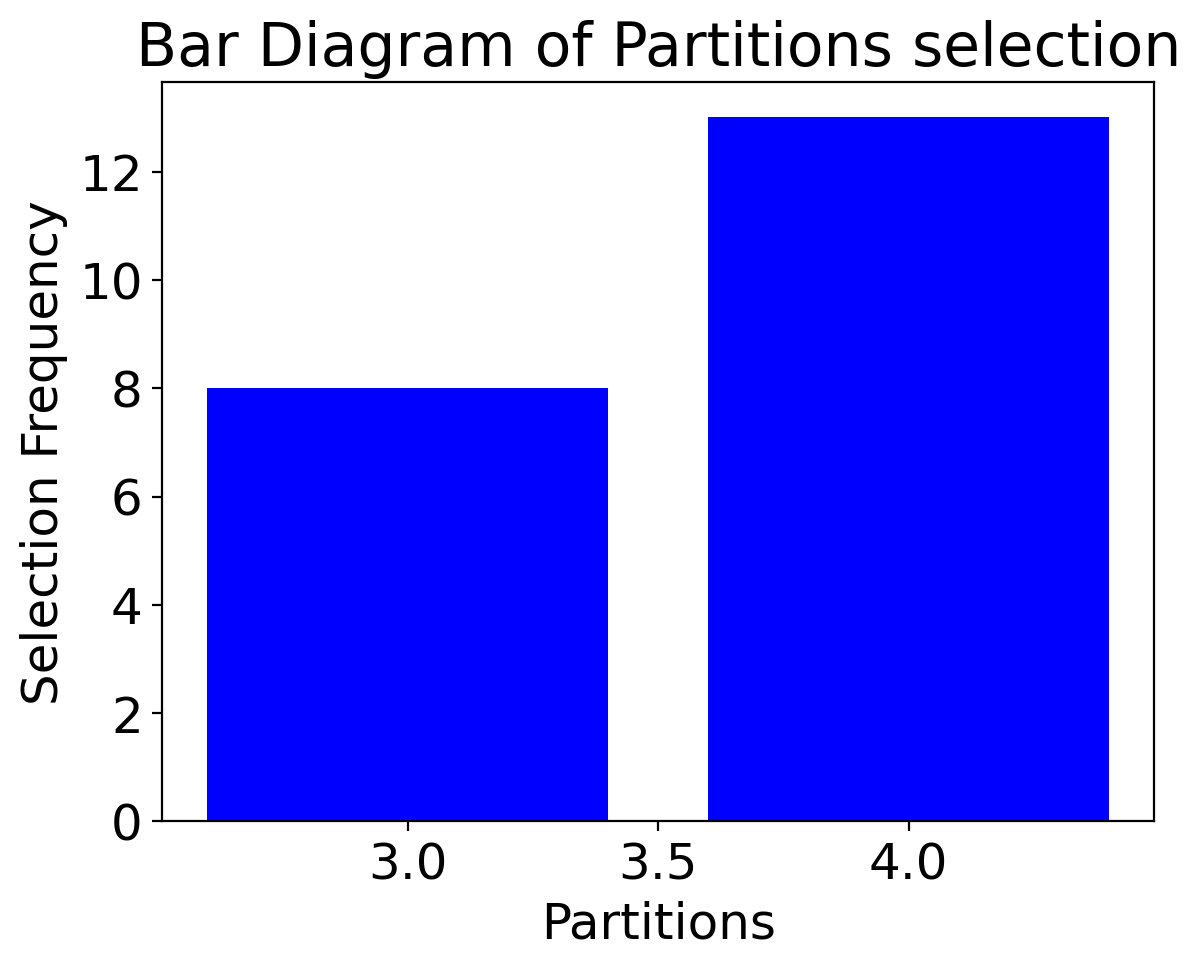

In [586]:
plt.figure(2)
data = cluster_count
counter = Counter(data)

numbers = list(counter.keys())
frequencies = list(counter.values())

plt.bar(numbers, frequencies, color='blue')
plt.xlabel('Partitions')
plt.ylabel('Selection Frequency')
plt.title('Bar Diagram of Partitions selection')

plt.show()

In [587]:
'''folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Effectiveness of Sys'
file_name = 'Employment_neural_acc.pdf'
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)
plt.figure(figsize=(10,8))
#plt.plot(MAB_inf_iteration_count_ex, MAB_inf_accuracy_ex, color='m',marker='v', linestyle='-', label='SYS_INF')
plt.plot(i_values_ex_stat, acc_stat, color='orange',marker='v', linestyle='-', label='SYS')
plt.plot(i_values_ran, acc_ran, color='b', marker='^', linestyle='-', label='Random')
#plt.plot(i_values_ex_inf, acc_inf, color='lightblue',marker='v', linestyle='-', label='INF')
plt.plot(i_values_ent, acc_ent, color='skyblue', marker='^', linestyle='-', label='Entropy')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=35)
plt.ylabel('Accuracy', fontsize=35)
plt.legend(fontsize=25)


plt.tick_params(axis='both', which='major', labelsize=35)
plt.tight_layout()


#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()'''

"folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Effectiveness of Sys'\nfile_name = 'Employment_neural_acc.pdf'\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\nplt.figure(figsize=(10,8))\n#plt.plot(MAB_inf_iteration_count_ex, MAB_inf_accuracy_ex, color='m',marker='v', linestyle='-', label='SYS_INF')\nplt.plot(i_values_ex_stat, acc_stat, color='orange',marker='v', linestyle='-', label='SYS')\nplt.plot(i_values_ran, acc_ran, color='b', marker='^', linestyle='-', label='Random')\n#plt.plot(i_values_ex_inf, acc_inf, color='lightblue',marker='v', linestyle='-', label='INF')\nplt.plot(i_values_ent, acc_ent, color='skyblue', marker='^', linestyle='-', label='Entropy')\n\nplt.gca().xaxis.set_major_formatter(\n    mticker.FuncFormatter(\n        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'\n    )\n)\n\nplt.xlabel('% of Total Budget', fontsize=35)\nplt.ylabel('Acc

In [588]:
print('Initial Acc', accuracy_0)
print('Random Accuracy', acc_ran[-1])
print('Entropy Accuracy', acc_ent[-1])
print('AutoData Accuracy', acc_stat_dist[-1])
print('MAB Accuracy', acc_stat[-1])
print('Only Influence Accuracy', acc_inf[-1])
print('MAB_INF Accuracy', MAB_inf_accuracy_ex[-1])


Initial Acc 0.7654664860859122
Random Accuracy 0.7839674954641862
Entropy Accuracy 0.7839674954641862
AutoData Accuracy 0.7748703140571895
MAB Accuracy 0.7739503743643472
Only Influence Accuracy 0.7586180461503079
MAB_INF Accuracy 0.7603812638949224


## Efficiency

In [589]:
print('Random time', time_per_iteration_ran)
print('Entropy time', time_per_iteration_ent)
print('AutoData time', iteration_time1_dist)
print('MAB time', iteration_time1)
print('Only Influence time', time_per_iteration_inf)
print('MAB_INF time', iteration_time_MAB_inf)

Random time 3.036576747894287
Entropy time 3.3430421352386475
AutoData time 2.3170242309570312
MAB time 7.521347999572754
Only Influence time 3.1403746604919434
MAB_INF time 5.937386512756348


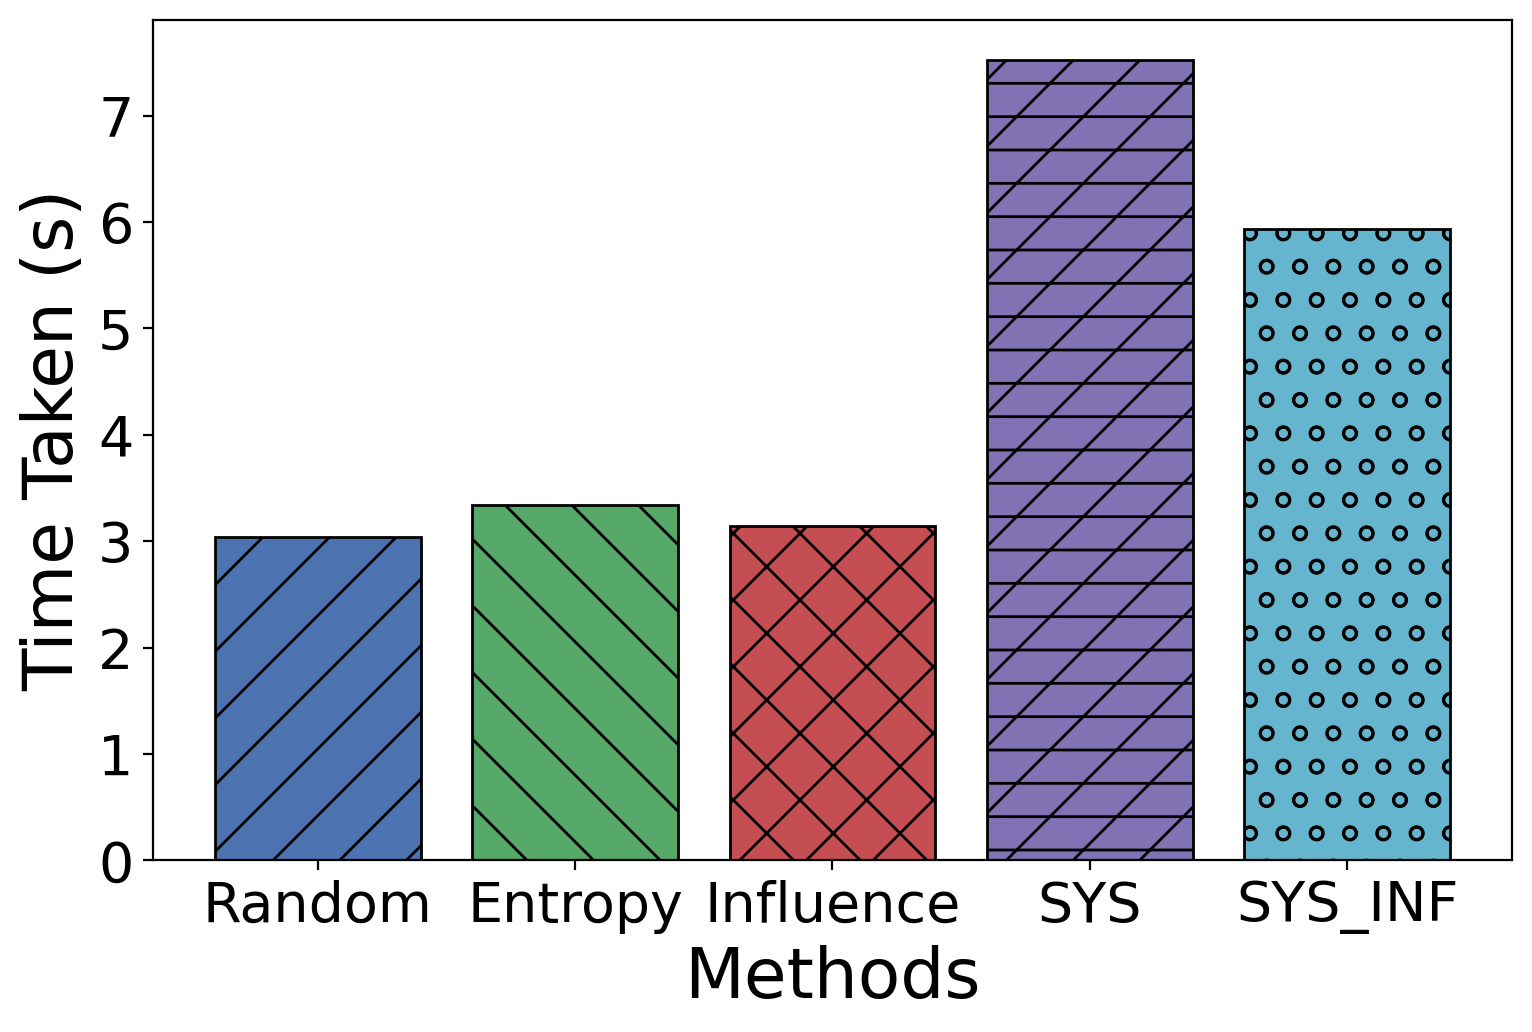

In [590]:
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Efficiency'
file_name = 'public .pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

methods = ['Random', 'Entropy','Influence', 'SYS', 'SYS_INF']
required_tme = [time_per_iteration_ran, time_per_iteration_ent, time_per_iteration_inf, iteration_time1, iteration_time_MAB_inf]

plt.figure(figsize=(8, 5.5))

hatch_patterns = ['/', '\\', 'x', '/-', 'o']
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#64B5CD']

bars = plt.bar(methods, required_tme, color=colors, edgecolor='black', linewidth=1, hatch=hatch_patterns)


plt.xlabel('Methods', fontsize=25)
plt.ylabel('Time Taken (s)', fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.gca().set_facecolor('white')

plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=600)
plt.show()


## Time Taken

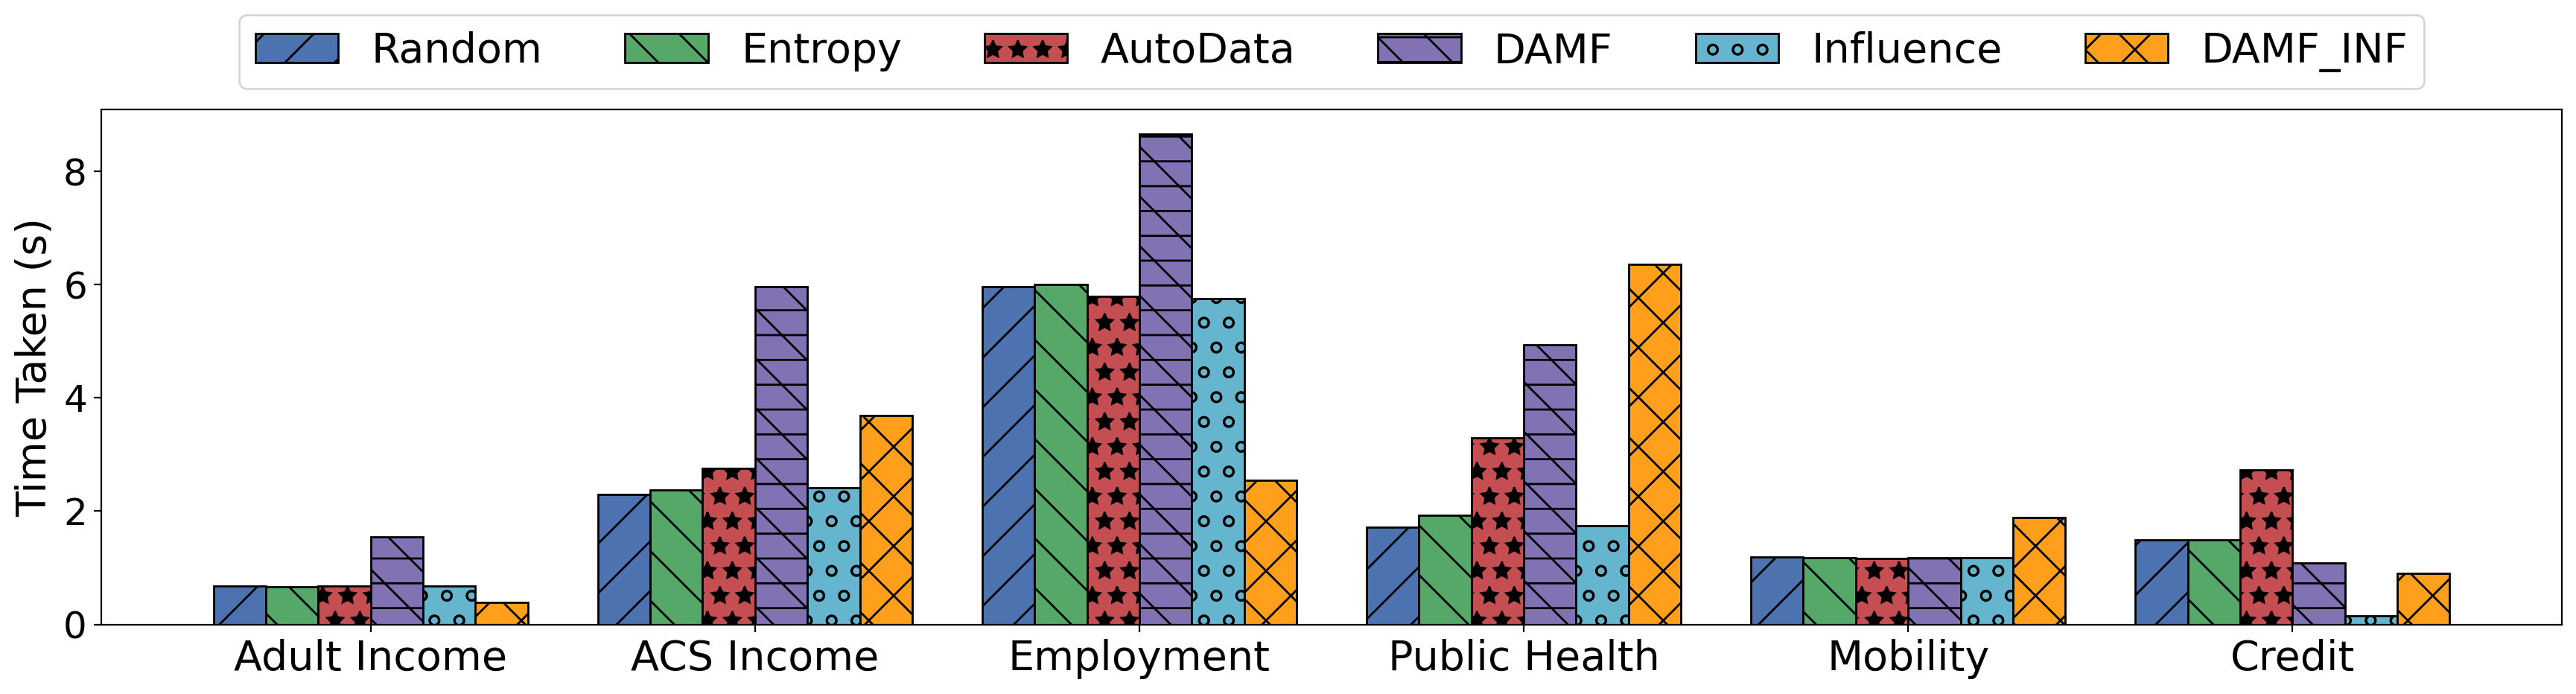

In [591]:
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Efficiency'
file_name = 'Efficiency_All.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

datasets = ['Adult Income', 'ACS Income', 'Employment', 'Public Health', 'Mobility', 'Credit']

methods = ['Random', 'Entropy', 'AutoData', 'DAMF', 'Influence', 'DAMF_INF']
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#64B5CD', '#FF9F1C']


required_time_dataset_1 = [0.677, 0.661, 0.672, 1.55, 0.68, 0.39]
required_time_dataset_2 = [2.30, 2.38, 2.76, 5.96, 2.41, 3.69]
required_time_dataset_3 = [5.97, 6.00, 5.79, 8.66, 5.76, 2.55]
required_time_dataset_4 = [1.718, 1.93, 3.30, 4.94, 1.75, 6.36]
required_time_dataset_5 = [1.187, 1.181, 1.17, 1.176, 1.173, 1.89]
required_time_dataset_6 = [1.49, 1.49, 2.73, 1.09, 0.15, 0.90]


required_times = [required_time_dataset_1, required_time_dataset_2, required_time_dataset_3, 
                  required_time_dataset_4, required_time_dataset_5, required_time_dataset_6]


hatch_patterns = ['/', '\\', '*', '\-', 'o', 'x']


n_datasets = len(datasets)
n_methods = len(methods)


bar_width = 0.15
gap = 0.2
index = np.arange(n_datasets) * (n_methods * bar_width + gap) 


plt.figure(figsize=(18, 5))


for i, (method, color, hatch) in enumerate(zip(methods, colors, hatch_patterns)):
    plt.bar(index + i * bar_width, [time[i] for time in required_times], 
            bar_width, label=method, color=color, edgecolor='black', hatch=hatch)




plt.ylabel('Time Taken (s)', fontsize=20)
plt.xticks(index + bar_width * (n_methods - 1) / 2, datasets, fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1), loc='lower center', ncol=n_methods)



plt.gca().set_facecolor('white')
plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=600)
plt.show()



## Sensitivity Analysis

## Clustering Method

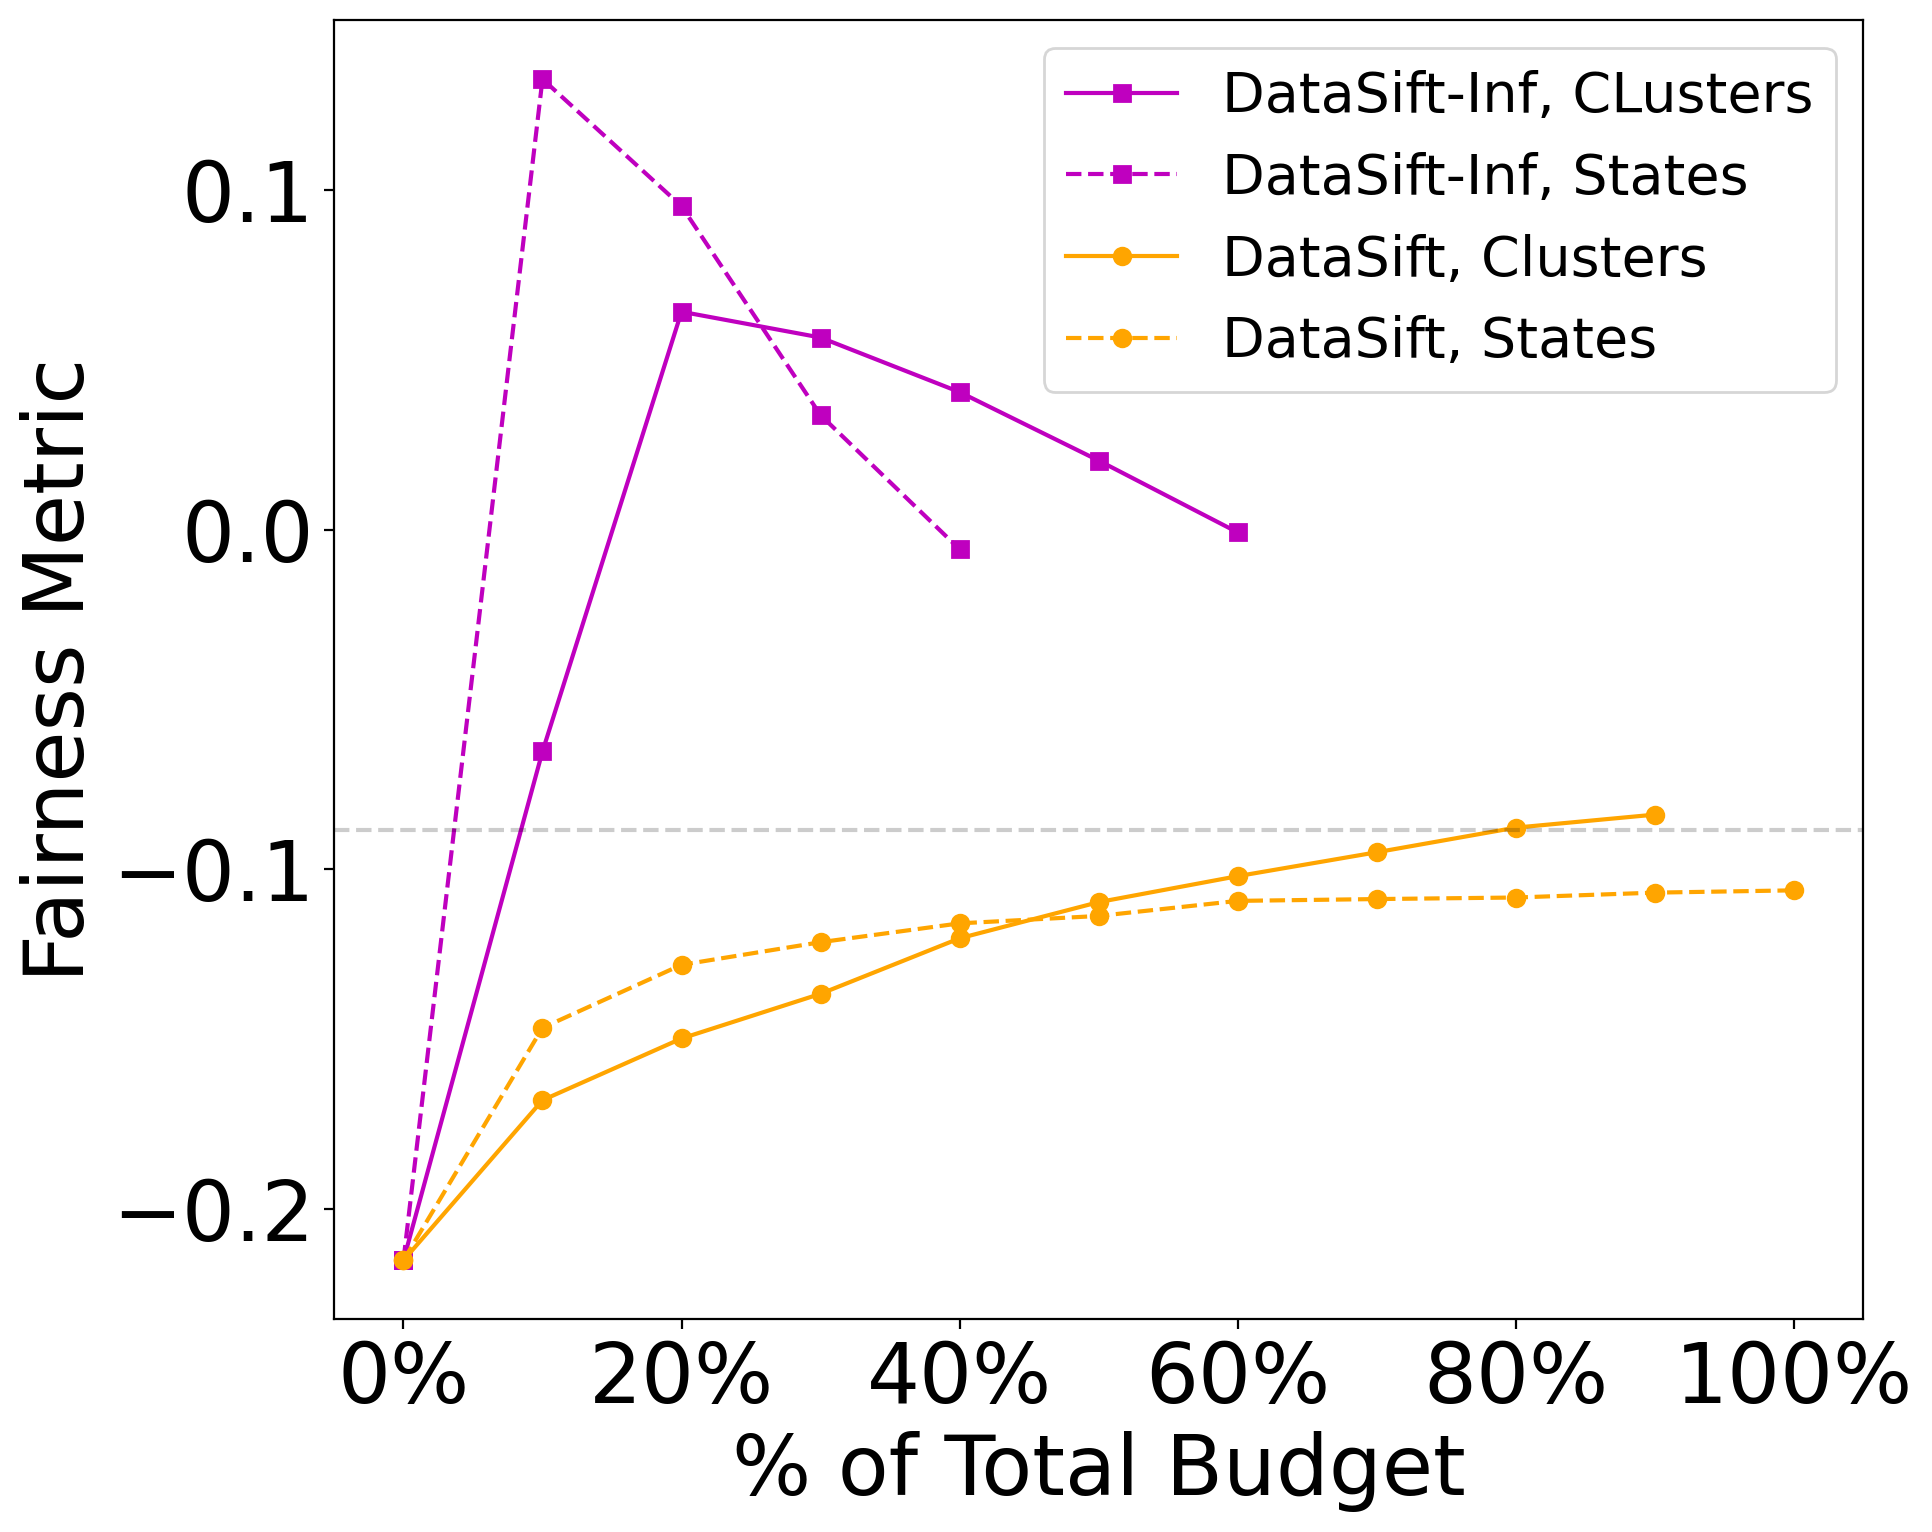

In [610]:
'''folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper parameter Final'
file_name = 'partitioning method.pdf'


os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(10,8))

plt.plot(
    [i for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    [MAB_inf_parity_ex[MAB_inf_iteration_count_ex.index(i)] for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    color='m', marker='s', linestyle='-', label='DataSift-Inf, CLusters'
)
plt.plot(
    [i for i in MAB_inf_iteration_count_ex_pa if i % 1 == 0], 
    [MAB_inf_parity_ex_pa[MAB_inf_iteration_count_ex_pa.index(i)] for i in MAB_inf_iteration_count_ex_pa if i % 1 == 0], 
    color='m', marker='s', linestyle='--', label='DataSift-Inf, States'
)

plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='orange', marker='o', linestyle='-', label='DataSift, Clusters'
)

plt.plot(
    [i for i in i_values_ex_stat_pa if i % 1 == 0], 
    [stat_ex_pa[i_values_ex_stat_pa.index(i)] for i in i_values_ex_stat_pa if i % 1 == 0], 
    color='orange', marker='o', linestyle='--', label='DataSift, States'
)



plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')


plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)


plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=20, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()


plt.savefig(file_path, format='pdf', dpi=600)
plt.show()'''

In [593]:
Stat_update_data_base, i_values_stat_base, i_values_ex_stat_base, stat_ex_base, stat_base, acc_stat_base, time_per_iteration_stat_base, cluster_count_base, iteration_time1_baseemployemempl = mab_algorithm_base(clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=20, tau=0.025, budget=data_acq_size, alpha=0.1)

## Reward Score Selection

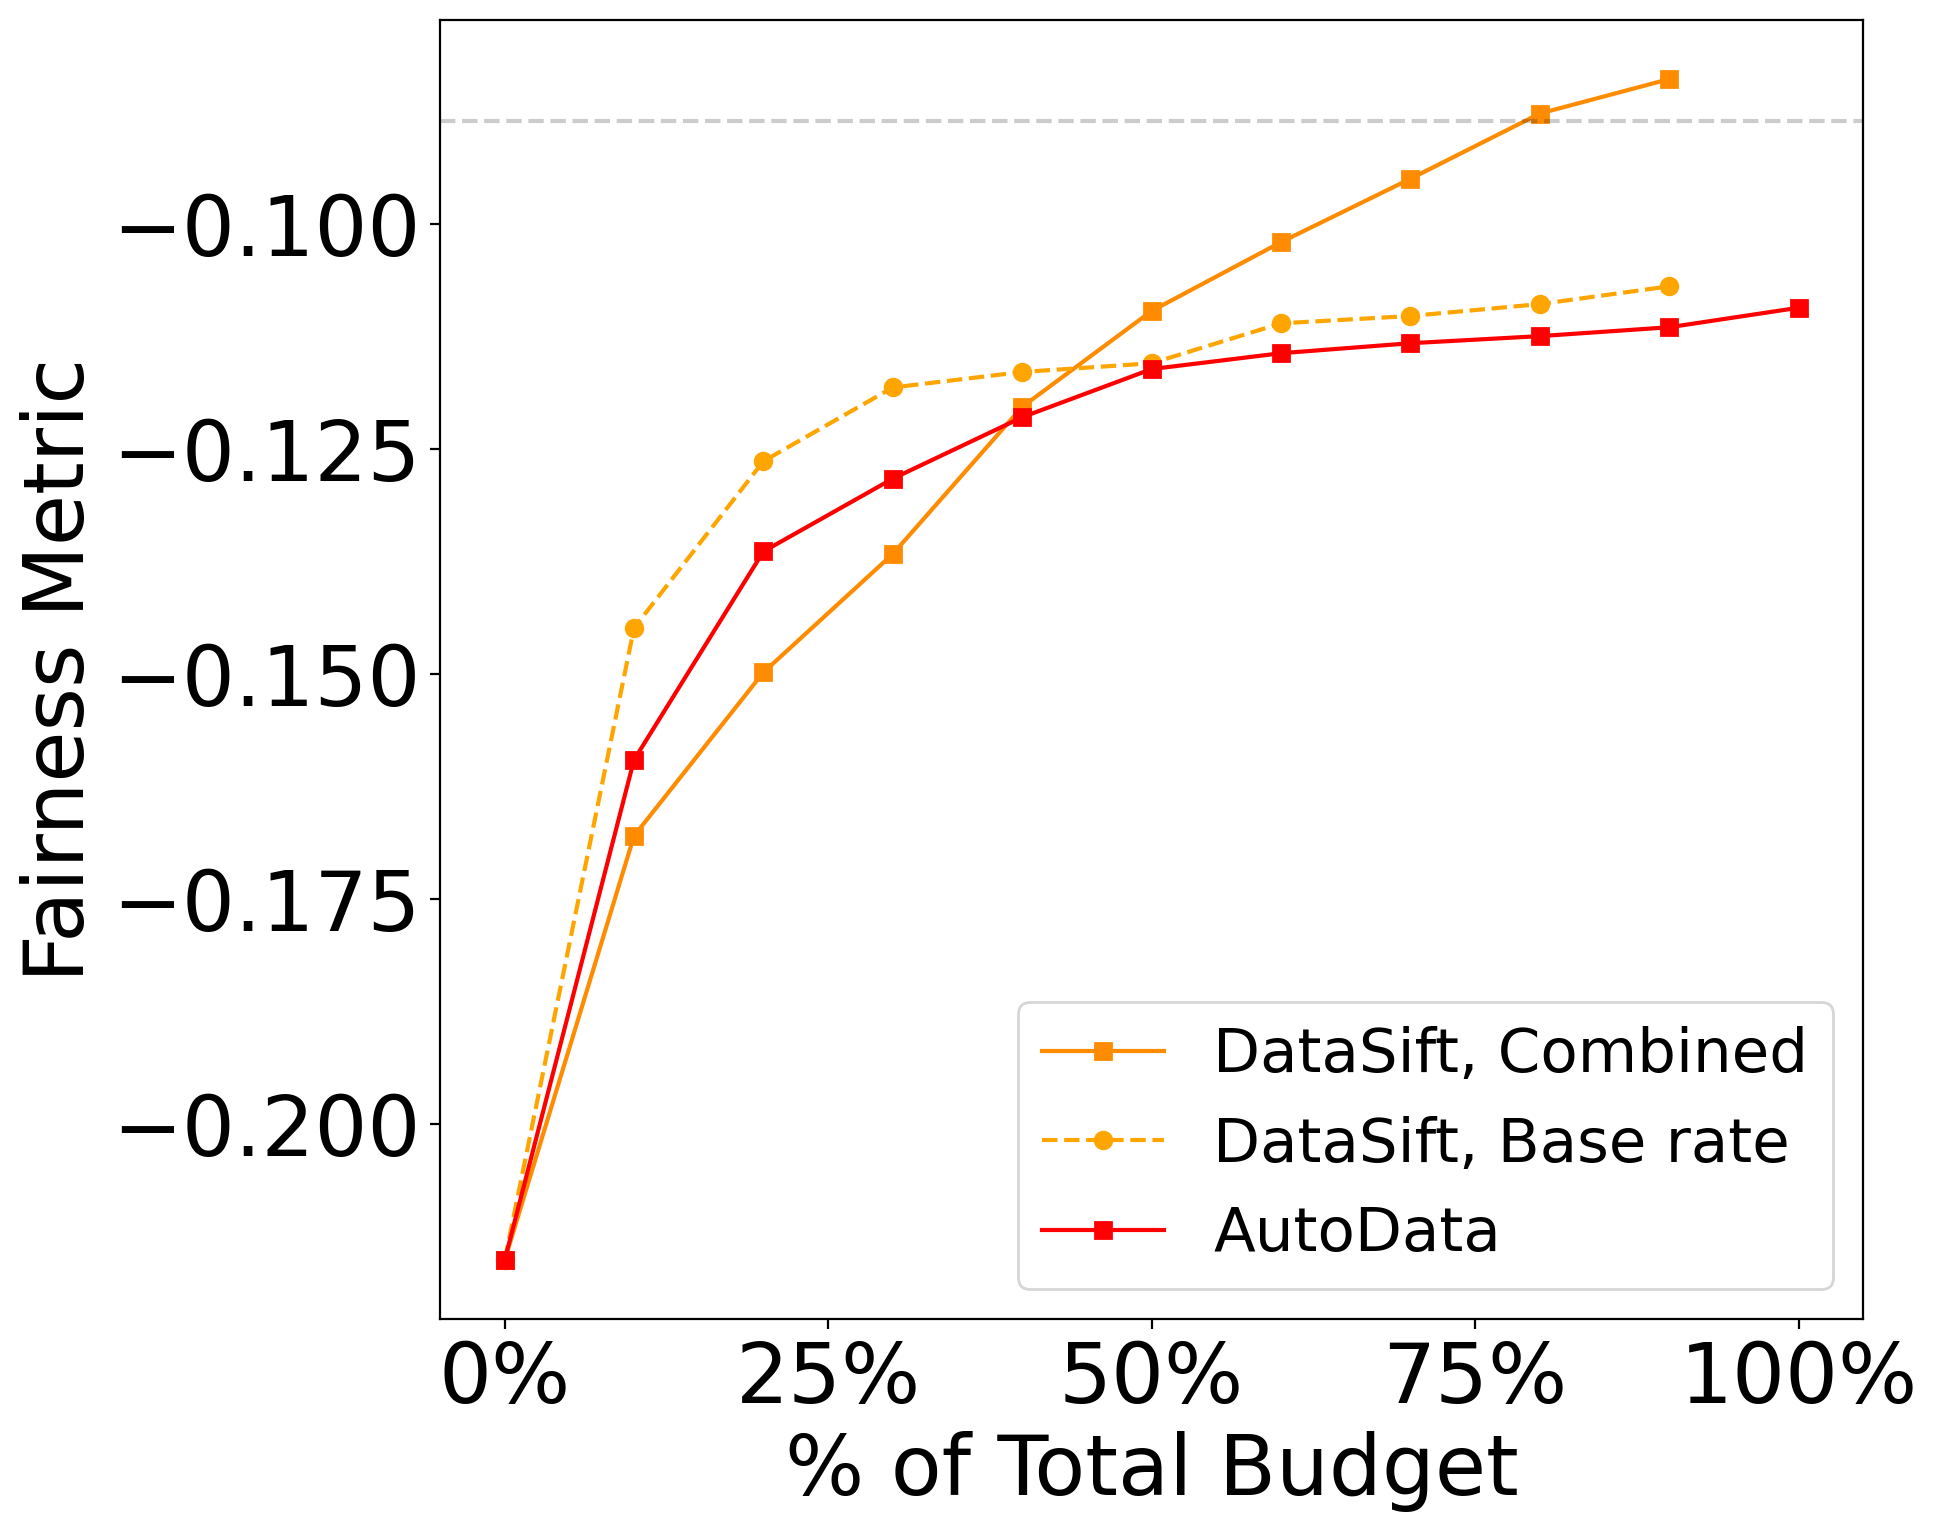

In [609]:
'''folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper parameter Final'
file_name = 'Reward-Score Selection.pdf'


os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(10,8))

plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='#FF8C00', marker='s', linestyle='-', label='DataSift, Combined'
)
plt.plot(
    [i for i in i_values_ex_stat_base if i % 1 == 0], 
    [stat_ex_base[i_values_ex_stat_base.index(i)] for i in i_values_ex_stat_base if i % 1 == 0], 
    color='orange', marker='o', linestyle='--', label='DataSift, Base rate'
)
plt.plot(
    [i for i in i_values_ex_stat_dist if i % 1 == 0], 
    [stat_ex_dist[i_values_ex_stat_dist.index(i)] for i in i_values_ex_stat_dist if i % 1 == 0], 
    color='r', marker='s', linestyle='-', label='AutoData'
)

plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')


plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)


plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=22, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()


plt.savefig(file_path, format='pdf', dpi=600)
plt.show()'''

## ALpha

In [595]:
'''alpha = [0, 0.001, 0.01, 0.1, 1]
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper parameter Final'
file_name = 'Alpha.pdf'


os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)
plt.figure(figsize=(10, 8))


cmap = plt.get_cmap('Oranges')
colors = cmap(np.linspace(0.3, 0.9, len(alpha)))


for idx, (i, color) in enumerate(zip(alpha, colors)):
    Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(
        clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute,
        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=i)
    
    plt.plot(i_values_ex_stat, stat_ex, marker='s', linestyle='-', label=f'α={i}', color=color)


plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=30, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()


#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()'''

"alpha = [0, 0.001, 0.01, 0.1, 1]\nfolder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper parameter Final'\nfile_name = 'Alpha.pdf'\n\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\nplt.figure(figsize=(10, 8))\n\n\ncmap = plt.get_cmap('Oranges')\ncolors = cmap(np.linspace(0.3, 0.9, len(alpha)))\n\n\nfor idx, (i, color) in enumerate(zip(alpha, colors)):\n    Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(\n        clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute,\n        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=i)\n    \n    plt.plot(i_values_ex_stat, stat_ex, marker='s', linestyle='-', label=f'α={i}', color=color)\n\n\nplt.gca().xaxis.set_major_formatter(\n    mticker.FuncFormatter(\n        lambd

## Synthetic DataSet

In [596]:
size = ['Original', 1e5, 2e5, 5e5, 1e6]
fairness_sys=[-0.08626, -0.1611, -0.03421, -0.0907, -0.0603]
fairness_sys_inf=[-0.01561, 0.00731, -0.01231, -0.01489, -0.01139]
time_sys=[1.58,1.13,0.9295, 0.6928, 2.9274]
time_sys_inf=[0.569,0.38, 0.92, 0.95, 4.738]

"size = ['Original', 1e5, 2e5, 5e5, 1e6]\nfairness_sys=[-0.08626, -0.1611, -0.03421, -0.0907, -0.0603]\nfairness_sys_inf=[-0.01561, 0.00731, -0.01231, -0.01489, -0.01139]\ntime_sys=[1.58,1.13,0.9295, 0.6928, 2.9274]\ntime_sys_inf=[0.569,0.38, 0.92, 0.95, 4.738]"

In [597]:
'''folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper Parameter'
file_name = 'Synthetic.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)
size = ['Original', '1e5', '2e5', '5e5', '1e6']

plt.figure(figsize=(10, 8))
plt.plot(size, fairness_sys_inf, color='m', marker='s', linestyle='-', label='DAMF_inf')
plt.plot(size, fairness_sys, color='orange', marker='s', linestyle='-', label='DAMF')

plt.xticks(range(len(size)), size)


plt.xlabel('Synthetic Dataset Size', fontsize=25)
plt.ylabel('Fairness Metric', fontsize=25)
plt.legend(loc='lower right', bbox_to_anchor=(0.999, 0.001),fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.savefig(file_path)
plt.show()'''

"folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper Parameter'\nfile_name = 'Synthetic.pdf'\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\nsize = ['Original', '1e5', '2e5', '5e5', '1e6']\n\nplt.figure(figsize=(10, 8))\nplt.plot(size, fairness_sys_inf, color='m', marker='s', linestyle='-', label='DAMF_inf')\nplt.plot(size, fairness_sys, color='orange', marker='s', linestyle='-', label='DAMF')\n\nplt.xticks(range(len(size)), size)\n\n\nplt.xlabel('Synthetic Dataset Size', fontsize=25)\nplt.ylabel('Fairness Metric', fontsize=25)\nplt.legend(loc='lower right', bbox_to_anchor=(0.999, 0.001),fontsize=20)\nplt.tick_params(axis='both', which='major', labelsize=25)\nplt.savefig(file_path)\nplt.show()"

In [598]:
'''folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper Parameter'
file_name = 'Synthetic_efficiency.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)
size = ['Original', '1e5', '2e5', '5e5', '1e6']

plt.figure(figsize=(10, 8))
plt.plot(size, time_sys_inf, color='m', marker='s', linestyle='-', label='DAMF_inf')
plt.plot(size, time_sys, color='orange', marker='s', linestyle='-', label='DAMF')

plt.xticks(range(len(size)), size)


plt.xlabel('Synthetic Dataset Size', fontsize=25)
plt.ylabel('Time(s)', fontsize=25)
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.savefig(file_path)
plt.show()'''

"folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper Parameter'\nfile_name = 'Synthetic_efficiency.pdf'\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\nsize = ['Original', '1e5', '2e5', '5e5', '1e6']\n\nplt.figure(figsize=(10, 8))\nplt.plot(size, time_sys_inf, color='m', marker='s', linestyle='-', label='DAMF_inf')\nplt.plot(size, time_sys, color='orange', marker='s', linestyle='-', label='DAMF')\n\nplt.xticks(range(len(size)), size)\n\n\nplt.xlabel('Synthetic Dataset Size', fontsize=25)\nplt.ylabel('Time(s)', fontsize=25)\nplt.legend(fontsize=20)\nplt.tick_params(axis='both', which='major', labelsize=25)\nplt.savefig(file_path)\nplt.show()"

## Mini-Batch Size

In [599]:
'''mini_batch_pct = [2, 4, 6, 8, 10, 12, 15]
budget_pct = 20
data_acq_size = int(datapool.shape[0] * budget_pct // 100)

x_values = mini_batch_pct

mab_values = []
mab_inf_values = []
inf_values = []
random_values = []
entropy_values = []

for i in mini_batch_pct:
    mini_batch_size = int(data_acq_size * (i / 100))

    Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(
        clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, 
        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=0.1)
    mab_values.append(stat_ex[-1])

    MAB_inf_update_data, MAB_inf_iteration_count, MAB_inf_iteration_count_ex, MAB_inf_parity_ex, stat_MAB_inf, MAB_inf_accuracy_ex, MAB_inf_time_per_iteration, MAB_inf_cluster_count, iteration_time_MAB_inf = mab_inf_algorithm(
        sort_by_inf_partition, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, 
        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=0.1)
    mab_inf_values.append(MAB_inf_parity_ex[-1])'''


'mini_batch_pct = [2, 4, 6, 8, 10, 12, 15]\nbudget_pct = 20\ndata_acq_size = int(datapool.shape[0] * budget_pct // 100)\n\nx_values = mini_batch_pct\n\nmab_values = []\nmab_inf_values = []\ninf_values = []\nrandom_values = []\nentropy_values = []\n\nfor i in mini_batch_pct:\n    mini_batch_size = int(data_acq_size * (i / 100))\n\n    Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(\n        clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, \n        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=0.1)\n    mab_values.append(stat_ex[-1])\n\n    MAB_inf_update_data, MAB_inf_iteration_count, MAB_inf_iteration_count_ex, MAB_inf_parity_ex, stat_MAB_inf, MAB_inf_accuracy_ex, MAB_inf_time_per_iteration, MAB_inf_cluster_count, iteration_time_MAB_inf = mab_inf_algorithm(\n        sort_by_inf_partition, dataset_name,

In [600]:
'''folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper parameter Final'
file_name = 'Mini-batch.pdf'


os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(10, 8))

plt.plot(x_values, mab_values, marker='o', linestyle='-', color='orange', label='DataSift')
plt.plot(x_values, mab_inf_values, marker='s', linestyle='-', color='purple', label='DataSift-Inf')

plt.xlabel('Batch Size (%)', fontsize=20)
plt.ylabel('Fairness Metric', fontsize=20)

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f'{x:.0f}%')
)

plt.xlabel('Batch Size: as % of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=26, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=28)
plt.tight_layout()
#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()'''

"folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Hyper parameter Final'\nfile_name = 'Mini-batch.pdf'\n\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\n\nplt.figure(figsize=(10, 8))\n\nplt.plot(x_values, mab_values, marker='o', linestyle='-', color='orange', label='DataSift')\nplt.plot(x_values, mab_inf_values, marker='s', linestyle='-', color='purple', label='DataSift-Inf')\n\nplt.xlabel('Batch Size (%)', fontsize=20)\nplt.ylabel('Fairness Metric', fontsize=20)\n\nplt.gca().xaxis.set_major_formatter(\n    mticker.FuncFormatter(lambda x, _: f'{x:.0f}%')\n)\n\nplt.xlabel('Batch Size: as % of Total Budget', fontsize=30)\nplt.ylabel('Fairness Metric', fontsize=30)\nplt.legend(fontsize=26, ncol=1)\n\n\nplt.tick_params(axis='both', which='major', labelsize=28)\nplt.tight_layout()\n#plt.savefig(file_path, format='pdf', dpi=600)\nplt.show()"